In [36]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn import metrics
print(torch.cuda.is_available())
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from vis_model_high import lung_finetune_flex,ReconstructionModel,SegmentationModel,BaseModel
from utils import *
from predict import model_predict, sr_predict_lung_segmentation, sr_predict_lung_segmentation_spot
from dataset import ViT_HER2ST, ViT_SKIN,HER2ST,LUNG,LUNG_HD
from PIL import Image
import glob
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy import stats
import scanpy as sc
import cv2
import anndata
import torch.nn.functional as F
from skimage.segmentation import watershed
os.environ["TORCH_CPP_LOG_LEVEL"]="INFO"
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "DETAIL"
# Check if CUDA is available
print(torch.cuda.is_available())
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import scipy.sparse

True
True


In [37]:
if torch.cuda.is_available():
    # Reset/release all CUDA memory
    torch.cuda.empty_cache()

    # Additional step to reset all CUDA tensors (optional)
    torch.cuda.ipc_collect()
!nvidia-smi

Thu Dec  5 05:22:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:07:00.0 Off |                    0 |
| N/A   33C    P0             65W /  400W |     425MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import cv2
import os
import numpy as np
import scipy.sparse
from skimage.color import rgb2gray
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import tifffile as tiff
# from scipy import ndimage
# from skimage.measure import regionprops
# from PIL import Image
def stardist(image_array, labels_npz_path, stardist_model="2D_versatile_he", block_size=4096*2, min_overlap=128, context=128, **kwargs):
    '''
    Segment an image with StarDist. Supports both the fluorescence and 
    H&E models. The identified object labels will be converted to a 
    sparse matrix and written to drive in ``.npz``.
    
    Input
    -----
    image_array : ``numpy array``
        Image to be segmented.
    labels_npz_path : ``filepath``
        Path to write object labels output. Can be easily loaded via 
        ``scipy.sparse.load_npz()``.
    stardist_model : ``str``, optional (default: ``"2D_versatile_he"``)
        Use ``"2D_versatile_he"`` for segmenting H&E images or 
        ``"2D_versatile_fluo"`` for segmenting GEX-derived single-channel 
        images
    block_size : ``int``, optional (default: 4096)
        StarDist ``predict_instances_big()`` input. Length of square edge 
        of the image to process as a single tile. 
    min_overlap : ``int``, optional (default: 128)
        StarDist ``predict_instances_big()`` input. Minimum overlap between 
        adjacent tiles, in each dimension.
    context : ``int``, optional (default: 128)
        StarDist ``predict_instances_big()`` input. Amount of image context 
        on all sides of a block, which is discarded.
    kwargs
        Any additional arguments to pass to StarDist. Practically most likely 
        to be ``prob_thresh`` for controlling the stringency of calling 
        objects.
    '''
    # Convert to grayscale if using the fluorescence model
    if stardist_model == "2D_versatile_fluo":
        image_array = rgb2gray(image_array)
        
    # Normalize the image
    img = normalize(image_array, 7, 99.8, axis=(0, 1))
    
    # Use pretrained stardist model
    model = StarDist2D.from_pretrained(stardist_model)
    
    # Specify axes
    if stardist_model == "2D_versatile_he":
        model_axes = "YXC"
    elif stardist_model == "2D_versatile_fluo":
        model_axes = "YX"
    
    # Run predict_instances_big() to perform automated tiling of the input
    labels, _ = model.predict_instances_big(img, axes=model_axes, 
                                            block_size=block_size, 
                                            min_overlap=min_overlap, 
                                            context=context, 
                                            **kwargs
                                           )
    
    # Store resulting labels as sparse matrix NPZ
    labels_sparse = scipy.sparse.csr_matrix(labels)
    scipy.sparse.save_npz(labels_npz_path, labels_sparse)
    print("Found " + str(len(np.unique(labels_sparse.data))) + " objects")
    return labels
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = '/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/Visium_HD_Human_Colon_Cancer_P1_tissue_image.btf'
    print(os.path.exists(img_fold))
    img_color = cv2.imread(img_fold, cv2.IMREAD_UNCHANGED).astype(np.float32)
    img_color=img_color[:,:,0:3]
    #print(img_color.shape,'shape')
    # img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    #print(img_color.shape,'shape1')
    return img_color
names = ['P1_CRC']
def read_bigtiff_in_chunks(file_path, chunk_size):
    with tiff.TiffFile(file_path) as tif:
        # Get image dimensions
        image_shape = tif.series[0].shape
        height, width = image_shape[:2]
        channels = 1 if len(image_shape) == 2 else image_shape[2]

        # Create an empty array to store the image
        image = np.zeros((height, width, channels), dtype=np.float32)

        # Read the image in chunks
        for i in range(0, height, chunk_size):
            for j in range(0, width, chunk_size):
                chunk = tif.asarray(key=0)[i:i+chunk_size, j:j+chunk_size, :channels]
                image[i:i+chunk_size, j:j+chunk_size, :channels] = chunk

    return image
def read_large_tiff(file_path):
    # Read the image using tifffile
    img_color = tiff.imread(file_path).astype(np.float32)

    # If the image has more than three channels, select only the first three
    if img_color.ndim == 3 and img_color.shape[2] > 3:
        img_color = img_color[:, :, 0:3]

    return img_color
chunk_size = 1024  # Example chunk size
btf_file_path='/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/Visium_HD_Human_Colon_Cancer_P1_tissue_image.btf'
# Read the BigTIFF file in chunks
image_rgb = read_large_tiff(btf_file_path)

# print(names[0])
# image_rgb = get_img(names[0])


RuntimeError: Please install TensorFlow: https://www.tensorflow.org/install/

In [3]:
image_array = np.array(image_rgb)
np.save('/ix1/wchen/Zhaochongyue/spatial/crc_image_rgb.npy', image_array)
labels_npz_path = '/ix1/wchen/Zhaochongyue/spatial/crc_labels.npz'
labels=stardist(image_array, labels_npz_path)

NameError: name 'image_rgb' is not defined

In [ ]:
# Plot the labels
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='gray')
plt.title('Segmented Labels')
plt.axis('off')
plt.show()

In [38]:
def get_cnt(name):
    if name in ['A1', 'A2', 'A3','A4']:
        input_dir = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name, 'outs/')
    else:
        input_dir = os.path.join('/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/binned_outputs/', 'square_008um/')
    input_path=os.path.join(input_dir,"filtered_feature_bc_matrix.h5")
    adata = sc.read_10x_h5(input_path)
    adata.var_names_make_unique()
    # sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000)
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # sc.pp.log1p(adata)
    # adata = adata[:, adata.var['highly_variable']]
    #print(adata,'adata')
    if name in ['A1', 'A2', 'A3','A4']:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions_list.csv")
    else:
        file_Adj = os.path.join(input_dir, "spatial/tissue_positions.parquet")
    if name in ['A1', 'A2', 'A3','A4']:
        positions = pd.read_csv(file_Adj, header=None)
        positions.columns = [
                'barcode',
                'in_tissue',
                'array_row',
                'array_col',
                'pxl_row_in_fullres',
                'pxl_col_in_fullres',
        ]
    else:
        positions = pd.read_parquet(file_Adj)
        
        # Set the index to barcode for merging
    positions.set_index('barcode', inplace=True)
    positions = positions[positions['in_tissue'] == 1]

# Identify overlapping columns
    overlap_columns = adata.obs.columns.intersection(positions.columns)

        # Identify overlapping columns
    # overlap_columns = adata.obs.columns.intersection(positions.columns)

    # Decide how to resolve conflicts for overlapping columns
    # Here, we'll keep the column from `positions` and discard the one from `adata.obs`
    for col in overlap_columns:
        adata.obs[col] = positions[col]

    # If there are additional columns in `positions` that are not in `adata.obs`,
    # you might want to merge them into `adata.obs`
    non_overlap_columns = positions.columns.difference(adata.obs.columns)
    adata.obs = adata.obs.join(positions[non_overlap_columns], how="left")
    adata.obsm['spatial'] = adata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()
    return adata
names = ['P1_CRC']
adata=get_cnt(names[0])
# Extract the spatial data
spatial_data = adata.obsm['spatial']

# Check if adata.obsm['spatial'] has any negative values and find the indices
negative_indices = np.where(spatial_data < 0)
negative_rows = np.unique(negative_indices[0])

# Filter out the rows with negative values in adata.obsm['spatial']
if len(negative_rows) > 0:
    adata = adata[~adata.obs.index.isin(adata.obs.index[negative_rows])]

    # Reassign the spatial data to adata.obsm['spatial'] after filtering
    adata.obsm['spatial'] = adata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']].to_numpy()

print(f"Filtered adata has {adata.shape[0]} bins and {adata.shape[1]} genes.")

Filtered adata has 507684 bins and 18085 genes.


In [39]:
spatial_data = adata.obsm['spatial']
has_negative_values = np.any(spatial_data < 0)

print(f"Does adata.obsm['spatial'] contain negative values? {has_negative_values}")

# Optionally, print the indices and values of the negative entries for further inspection
if has_negative_values:
    negative_indices = np.where(spatial_data < 0)
    print("Indices of negative values in adata.obsm['spatial']:", negative_indices)
    print("Negative values in adata.obsm['spatial']:", spatial_data[negative_indices])

Does adata.obsm['spatial'] contain negative values? False


In [40]:
import h5py
h5_file_path = '/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/singlecell/HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5'
adata_sc = sc.read_10x_h5(h5_file_path)
meta_data = pd.read_csv('/ix1/wchen/Zhaochongyue/spatial/SingleCell_MetaData.csv')
# Filter clusters with more than 25 cells
kp_idents = meta_data['Level2'].value_counts()[meta_data['Level2'].value_counts() > 25].index
filtered_meta_data = meta_data[meta_data['Level2'].isin(kp_idents)]
# Ensure barcodes match in format between adata and meta_data
adata_barcodes = adata_sc.obs_names
meta_data_barcodes = filtered_meta_data['Barcode']
# Check the intersection of barcodes
common_barcodes = np.intersect1d(adata_barcodes, meta_data_barcodes)
# Subset AnnData to only include the common barcodes
adata_sc = adata_sc[common_barcodes]
# Also filter the metadata to include only common barcodes
filtered_meta_data = filtered_meta_data[filtered_meta_data['Barcode'].isin(common_barcodes)]
# Set the Barcode as index to facilitate merging
filtered_meta_data.set_index('Barcode', inplace=True)
# Align the indices (barcodes) of the filtered metadata with the AnnData object
adata_sc.obs = adata_sc.obs.join(filtered_meta_data, how='left')

adata_sc.var_names_make_unique()

names = ['P1_CRC']
datasets = {}
# all_centroids = []  # List to store all centroids
# all_images = []  # List to store all images
for name in names:
    datasets[name] = get_cnt(name)
    datasets[name].var_names_make_unique()
# Find common genes between single-cell and other datasets
common_genes = set(adata_sc.var_names)
for data in datasets.values():
    common_genes.intersection_update(set(data.var_names))
adata_sc = adata_sc[:, list(common_genes)]
for name in datasets:
    datasets[name] = datasets[name][:, list(common_genes)]
adata_sc = adata_sc[adata_sc.obs['QCFilter'] == "Keep"]
adata_sc2=adata_sc

sc.pp.normalize_total(adata_sc, target_sum=1e4)

sc.pp.log1p(adata_sc)


                      Barcode Patient   BC QCFilter       Level1       Level2
0  AAACAAGCAACAGCACACTTTAGG-1   P2CRC  BC1   Remove  QC_Filtered  QC_Filtered
1  AAACAAGCAACAGCTAACTTTAGG-1   P2CRC  BC1     Keep      B cells       Plasma
2  AAACAAGCAACTGTTCACTTTAGG-1   P2CRC  BC1     Keep      T cells   CD4 T cell
3  AAACAAGCAAGGCCTGACTTTAGG-1   P2CRC  BC1     Keep        Tumor    Tumor III
4  AAACAAGCACATAGTGACTTTAGG-1   P2CRC  BC1     Keep        Tumor    Tumor III


In [41]:
from collections import defaultdict, Counter
from scipy.sparse import isspmatrix
sc.tl.rank_genes_groups(adata_sc, 'Level2', method='wilcoxon')
# Define the number of top marker genes to extract
marker_genes_data = sc.get.rank_genes_groups_df(adata_sc, group=None)
logfc_threshold = 0.2
min_diff_pct = 0.2
p_val_adj_threshold = 0.05
# Filter marker genes based on thresholds
filtered_markers = marker_genes_data[
    (marker_genes_data['logfoldchanges'] > logfc_threshold) & 
    (marker_genes_data['pvals_adj'] < p_val_adj_threshold)
]
# Calculate the percentage of cells expressing each gene in the group and reference populations
group_counts = adata_sc.obs['Level2'].value_counts()
gene_names = filtered_markers['names'].unique()
# Create a DataFrame to store the fractions
fractions = pd.DataFrame(index=gene_names, columns=group_counts.index)

for group in group_counts.index:
    group_idx = adata_sc.obs['Level2'] == group
    group_data = adata_sc[group_idx, gene_names].X > 0
    group_gene_counts = group_data.sum(axis=0).A1
    fractions[group] = group_gene_counts / group_counts[group]

# Calculate the rest of the population fractions
rest_fractions = (adata_sc[:, gene_names].X > 0).sum(axis=0).A1 / adata_sc.shape[0]

# Calculate the difference in fraction of expression
filtered_markers['pct_diff'] = filtered_markers.apply(
    lambda x: fractions.loc[x['names'], x['group']] - rest_fractions[gene_names.tolist().index(x['names'])], axis=1)

# Filter based on percentage difference
filtered_markers = filtered_markers[filtered_markers['pct_diff'] > min_diff_pct]

# Select the top marker genes for each label
# Select the top marker genes for each label
top_marker_genes = defaultdict(list)
for group in adata_sc.obs['Level2'].unique():
    top_genes = filtered_markers[filtered_markers['group'] == group]['names'].tolist()
    top_marker_genes[group].extend(top_genes)

# Flatten the dictionary and count occurrences of each gene
all_genes = [gene for genes in top_marker_genes.values() for gene in genes]
gene_counts = Counter(all_genes)

# Filter out non-unique marker genes
unique_marker_genes = {group: [] for group in top_marker_genes.keys()}
for group, genes in top_marker_genes.items():
    unique_marker_genes[group] = [gene for gene in genes if gene_counts[gene] == 1]

# Use all unique marker genes instead of selecting top 5
selected_marker_genes = [gene for genes in unique_marker_genes.values() for gene in genes]

marker_dict = {
    'CD4 T cell': ['CD4'],  # List of markers for CD4+ T cells
    'CD8 Cytotoxic T cell': ['CD8A', 'PRF1', 'GZMA', 'GZMK','CXCL9', 'CXCL10','CXCL11'],  # List of markers for CD8+ T cells
    'Macrophage': ['C1QC', 'SELENOP', 'SPP1', 'STAB1','CD52','FBP1','IL1RN','FN1','LPL','CHI3L1','MMP7','CHIT1','CSF1R','MPEG1','MS4A6A','FGL2','SLC40A1','IGKC','CD209'],  # List of markers for Macrophages
    'Mature B':['JCHAIN','MZB1']
}

# Initialize the dictionary to store marker genes
small_marker_dict = defaultdict(list)

# Directly assign the predefined markers to the small_marker_dict
for cell_type, genes in marker_dict.items():
    small_marker_dict[cell_type].extend(genes)

# Extract the top 5 unique marker genes for each cell type
# unique_marker_genes = {}
for cell_type, genes in small_marker_dict.items():
    unique_marker_genes[cell_type] = list(set(genes))  # Ensure uniqueness

# Get the top 5 markers (if available)
top_5_unique_marker_genes = {group: genes[:5] for group, genes in unique_marker_genes.items()}
selected_marker_genes = [gene for genes in top_5_unique_marker_genes.values() for gene in genes if gene in common_genes]

marker_file_data = []
for group, genes in  top_5_unique_marker_genes.items():
    for gene in genes:
        marker_file_data.append({'gene': gene, 'label': group})
marker_file_df = pd.DataFrame(marker_file_data)

adata_sc_common = adata_sc[:, list(common_genes)].copy()
sc.pp.highly_variable_genes(adata_sc_common, n_top_genes=1000)
highly_variable_genes = adata_sc_common.var[adata_sc_common.var['highly_variable']].index.tolist()

# Combine selected marker genes and highly variable genes

final_gene_list = []
for gene in selected_marker_genes:
    if gene not in final_gene_list:
        final_gene_list.append(gene)

for gene in highly_variable_genes:
    if gene not in final_gene_list:
        final_gene_list.append(gene)
# If the combined list exceeds 1000 genes, trim it to 1000
if len(final_gene_list) > 1000:
    final_gene_list = final_gene_list[:1000]
with open('/ix1/wchen/Zhaochongyue/spatial/crc_hvg_list.pkl', 'wb') as f:
    pickle.dump(final_gene_list, f)
with open('/ix1/wchen/Zhaochongyue/spatial/crc_hvg_list.pkl', 'rb') as f:
    final_gene_list = pickle.load(f)
adata_sc = adata_sc2[:, final_gene_list]
data = adata_sc.X
if isspmatrix(data):  
   data = data.toarray()
data_min = data.min(axis=0)
data_max = data.max(axis=0)

adata_sc.X = (data - data_min) / (data_max - data_min+1e-12)


In [43]:
def value_binning(adata, B=10):
    # Function to bin values for a single spot or cell
    def bin_values(spot_or_cell_values, B):
        # Remove zero values and calculate bin edges
        non_zero_values = spot_or_cell_values[spot_or_cell_values > 0]
        if len(non_zero_values) == 0:
            return np.zeros(spot_or_cell_values.shape)
        
        # Calculate bin edges based on non-zero values in the current spot or cell
        bin_edges = np.percentile(non_zero_values, np.linspace(0, 100, B + 1))
        bin_edges[-1] = bin_edges[-1] + 1  # ensure the max value is included in the last bin

        # Bin the values
        binned_values = np.digitize(spot_or_cell_values, bins=bin_edges) - 1
        binned_values[spot_or_cell_values == 0] = 0  # retain zero values as zero

        return binned_values
    # Apply binning for each spot or cell
    binned_matrix = np.apply_along_axis(bin_values, 1, adata.X.toarray(), B)
    
    # Store the binned values back in adata object
    adata.X= binned_matrix
    
    return adata


In [44]:
adata = adata[:, final_gene_list]
data = adata.X
if isspmatrix(data):  
   data = data.toarray()
data_min = data.min(axis=0)
data_max = data.max(axis=0)

#         #print(data_min.shape,data.shape)
adata.X = (data - data_min) / (data_max - data_min+1e-12)


In [45]:
from sklearn.neighbors import NearestNeighbors 
import numpy as np 
import torch 
from scipy.sparse import issparse 
# Assuming adata_sc.X might be a sparse matrix or numpy array 
if issparse(adata_sc.X): 
    adata_tensor = torch.Tensor(adata_sc.X.toarray())  # Convert sparse matrix to dense numpy array, then to tensor 
else: 
    adata_tensor = torch.Tensor(adata_sc.X)  # Direct conversion to tensor if it's already a dense numpy array 

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
adata_tensor = adata_tensor

import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, classification_report 

X=adata_tensor
y = adata_sc.obs['Level2'].values 
# Encode labels numerically 
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y) 
# Split data into training and validation sets 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.01, random_state=42) 
import torch 
from torch.utils.data import DataLoader, TensorDataset 
from torch import nn 
from torch.optim import Adam 
# Assuming tensor conversions have already been done, move tensors to the chosen device 
tensor_X_train = torch.tensor(X_train, dtype=torch.float32).to(device) 
tensor_y_train = torch.tensor(y_train, dtype=torch.long).to(device) 
tensor_X_test = torch.tensor(X_test, dtype=torch.float32).to(device) 
tensor_y_test = torch.tensor(y_test, dtype=torch.long).to(device)  

# DataLoaders remain the same 
train_dataset_classi = TensorDataset(tensor_X_train, tensor_y_train) 
train_loader_classi  = DataLoader(train_dataset_classi, batch_size=1024, shuffle=True) 
test_dataset_classi  = TensorDataset(tensor_X_test, tensor_y_test) 
test_loader_classi  = DataLoader(test_dataset_classi, batch_size=1024, shuffle=False) 

In [46]:

class SimpleNN(torch.nn.Module): 
    def __init__(self,input_size): 
        super(SimpleNN, self).__init__() 
        self.fc1 = torch.nn.Linear(input_size, 128) 
        self.relu = torch.nn.ReLU() 
        self.dropout=nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(128, 32)  # Assuming 9 classes 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.relu(x) 
        x=self.dropout(x)
        x = self.fc2(x) 
        return x 
class FinePatchGeneEmbedding(nn.Module): 
    def __init__(self, in_channels,patch_size, emb_size): 
        super().__init__() 
        input_dim=in_channels*patch_size*patch_size
        self.embedding = nn.Sequential(nn.Linear(input_dim, 512),
                                       nn.ReLU(),
                                       nn.Linear(512,emb_size)
        )
    def forward(self, x):
        x=x.reshape(x.size(0),-1)
        return self.embedding(x) 
class IndexedAttentionAggregator(nn.Module): 
    def __init__(self, emb_size): 
        super().__init__() 
        self.query_transform = nn.Linear(emb_size, emb_size) 
        self.key = nn.Linear(emb_size, emb_size) 
        self.value = nn.Linear(emb_size, emb_size) 
        self.softmax = nn.Softmax(dim=2) 
    def forward(self, fine_embeddings, coarse_index): 
        unique_indices = coarse_index.unique(sorted=True) 
        valid_indices=[]
        aggregated_embeddings = torch.zeros(len(unique_indices), fine_embeddings.size(-1), device=fine_embeddings.device) 
        for i, idx in enumerate(unique_indices): 
            # mask=(coarse_index == idx)
            # print(fine_embeddings.shape)
            selected_embeddings = fine_embeddings[:,coarse_index == idx]  # Select embeddings for the current coarse index 
            # print(selected_embeddings.shape,'1')
            query = self.query_transform(torch.mean(selected_embeddings, dim=1, keepdim=True)) 
            keys = self.key(selected_embeddings) 
            values = self.value(selected_embeddings) 
            # print(query.shape,keys.shape,values.shape)
            attention_scores = torch.bmm(query, keys.transpose(1, 2)) / torch.sqrt(torch.tensor(keys.size(-1), dtype=torch.float32)) 
            attention_weights = self.softmax(attention_scores) 
            # print(attention_weights.shape,values.shape)
            # output=torch.bmm(attention_weights, values)
            # print(output.shape)
            aggregated_embeddings[i] = torch.bmm(attention_weights, values)
            valid_indices.append(idx.item())
        return aggregated_embeddings,torch.tensor(valid_indices).to(fine_embeddings.device)
class PatchToGeneModel(nn.Module): 
    def __init__(self, in_channels, fine_patch_size, emb_size,device):
        super().__init__() 
        self.fine_patch_gene_embedding = FinePatchGeneEmbedding(in_channels, fine_patch_size, emb_size)
        self.attention_aggregator = IndexedAttentionAggregator(emb_size)
        self.classifier=nn.Linear(384,18)
    def forward(self, fine_patches, coarse_index): 
        batch_size,num_patches, c, h, w = fine_patches.size() 
        fine_patches=fine_patches.view(batch_size*num_patches,c,h,w)
        # print(fine_patches.shape,fine_patches.device,self.fine_patch_gene_embedding,self.attention_aggregator)
        # Transform each fine patch to a gene embedding 
        fine_gene_embeddings =  self.fine_patch_gene_embedding(fine_patches)
        fine_gene_embeddings = fine_gene_embeddings.view(batch_size,num_patches, -1)  # Reshape back to batch format 
        # Aggregate using indexed attention based on coarse patch position 
        aggregated_gene_embeddings,valid_indices = self.attention_aggregator(fine_gene_embeddings, coarse_index) 
        predictions=self.classifier(aggregated_gene_embeddings)
        return aggregated_gene_embeddings, fine_gene_embeddings,valid_indices,predictions  # Return both aggregated and individual fine gene embeddings 

In [48]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors and transfer to GPU
N = adata.X.toarray() if isinstance(adata.X, scipy.sparse.csr_matrix) else adata.X  # [num_spots, num_genes]
spatial_coords = np.array(adata.obsm['spatial'])  # [num_spots, 2]
N_tensor = torch.tensor(N, dtype=torch.float32)
spatial_coords_tensor = torch.tensor(spatial_coords, dtype=torch.float32)
# Create the Lambda matrix from single-cell data
# Assuming single_cell_data and cell_type_labels are preprocessed
single_cell_df = pd.DataFrame(X)
single_cell_df['cell_type'] = y_encoded

# Calculate the average gene expression profile for each cell type
Lambda = single_cell_df.groupby('cell_type').mean().values

# Convert Lambda to a PyTorch tensor and transfer to GPU
Lambda_tensor = torch.tensor(Lambda, dtype=torch.float32).cuda()

# Create a dataset and DataLoader for the spot data
spot_dataset = TensorDataset(N_tensor, spatial_coords_tensor)
spot_loader = DataLoader(spot_dataset, batch_size=32, shuffle=False)

# Example shapes
num_genes = N_tensor.shape[1]
num_cell_types = Lambda_tensor.shape[0]
spatial_dim = spatial_coords_tensor.shape[1]


In [50]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
def construct_graph(data, coords, k_neighbors, batch_size):
    num_samples = data.shape[0]
    edge_index = []
    xs = []

    # Use k-d tree for efficient nearest neighbor search
    neighbors = NearestNeighbors(n_neighbors=k_neighbors, algorithm='kd_tree')
    neighbors.fit(coords)
    
    for batch_num, start in enumerate(range(0, num_samples, batch_size)):
        end = min(start + batch_size, num_samples)
        batch_coords = coords[start:end]
        distances, indices = neighbors.kneighbors(batch_coords)
        
        for i in range(len(indices)):
            for j in indices[i]:
                edge_index.append([i + start, j])
        
        x = torch.tensor(data[start:end], dtype=torch.float32)
        xs.append(x)
        
        # Print progress every 1000 batches
        if batch_num % 1000 == 0:
            print(f"Processed {batch_num * batch_size} samples")

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.cat(xs, dim=0)
    
    return Data(x=x, edge_index=edge_index)


In [51]:
from scipy.sparse import coo_matrix
def aggregate_gene_expressions(data):
    x, edge_index = data.x, data.edge_index
    num_nodes = x.size(0)
    
    # Create a sparse adjacency matrix
    values = np.ones(edge_index.size(1))
    indices = np.vstack((edge_index[0].cpu().numpy(), edge_index[1].cpu().numpy()))
    
    i = torch.tensor(indices, dtype=torch.long)
    v = torch.tensor(values, dtype=torch.float32)
    shape = (num_nodes, num_nodes)
    
    adj = torch.sparse_coo_tensor(i, v, shape)
    
    # Perform sum aggregation
    aggregated_expressions = torch.sparse.mm(adj, x)
    
    return aggregated_expressions


In [52]:
import torch

def classify_spots(aggregated_expressions, single_cell_classifier, device):
    single_cell_classifier.to(device)
    single_cell_classifier.eval()
    
    inputs = torch.tensor(aggregated_expressions).to(device)
    with torch.no_grad():
        outputs = single_cell_classifier(inputs)
        # print("Shape of outputs:", outputs.shape)  # Debugging line
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
    return predictions


In [53]:
from scipy.stats import mode

def determine_most_common_label(all_predictions):
    all_predictions = np.array(all_predictions)
    most_common_labels = mode(all_predictions, axis=0).mode[0]
    return most_common_labels

# Example usage
# most_common_labels = determine_most_common_label(all_predictions)
def prepare_visualization_data(coords, predictions):
    coords = np.array(coords)
    predictions = np.array(predictions)
    
    df = pd.DataFrame({
        'x': coords[:, 0],
        'y': coords[:, 1],
        'prediction': predictions
    })
    
    return df

# Step 6: Visualize Predictions
def visualize_predictions(df):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='prediction', palette='viridis', s=10)
    plt.title('Spatial Distribution of Predicted Labels')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(title='Predicted Label', loc='upper right')
    plt.show()

In [60]:
from scipy.spatial import distance
def select_top_k_informative_cells(single_cell_df, num_clusters=10, top_k=5):
    unique_types = single_cell_df['cell_type'].unique()
    informative_cells = []
    informative_types = []
    
    for cell_type in unique_types:
        type_df = single_cell_df[single_cell_df['cell_type'] == cell_type]
        type_features = type_df.drop(columns=['cell_type']).values
        
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        kmeans.fit(type_features)
        
        for i in range(num_clusters):
            cluster_indices = np.where(kmeans.labels_ == i)[0]
            cluster_cells = type_features[cluster_indices]
            centroid = kmeans.cluster_centers_[i]
            
            dists = np.linalg.norm(cluster_cells - centroid, axis=1)
            top_k_indices = cluster_indices[np.argsort(dists)[:top_k]]
            informative_cells.append(type_features[top_k_indices])
            informative_types.extend([cell_type] * len(top_k_indices))
    
    informative_cells = np.vstack(informative_cells)
    informative_types = np.array(informative_types)
    
    print(f"Shape of informative_cells: {informative_cells.shape}")
    print(f"Shape of informative_types: {informative_types.shape}")
    
    return informative_cells, informative_types

def find_nearest_same_type_by_expression(data_features, data_predictions, single_cell_features, single_cell_types):
    nearest_cells = []
    print(f"Shape of data_features: {data_features.shape}")
    print(f"Shape of data_predictions: {data_predictions.shape}")
    print(f"Shape of single_cell_features: {single_cell_features.shape}")
    print(f"Shape of single_cell_types: {single_cell_types.shape}")
    for idx, (spot_features, spot_type) in enumerate(zip(data_features, data_predictions)):
        same_type_cells = single_cell_features[single_cell_types == spot_type]
        
        if same_type_cells.shape[0] == 0:
            nearest_cells.append(None)
            continue
        
        dists = distance.cdist([spot_features], same_type_cells, 'euclidean')
        nearest_cell_idx = np.argmin(dists)
        nearest_cells.append(same_type_cells[nearest_cell_idx])
    
    return nearest_cells

def replace_spot_with_nearest_cell(data_features, nearest_cells):
    for idx, nearest_cell in enumerate(nearest_cells):
        if nearest_cell is not None:
            data_features[idx] = nearest_cell
    return data_features


In [61]:
# single_cell_df
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from torch import nn

# Assuming necessary functions classify_spots_with_scales, select_top_k_informative_cells,
# find_nearest_same_type_by_expression, and replace_spot_with_nearest_cell are defined as above
def group_spots_by_type_and_neighbors(spots_df, distance_threshold=50, batch_size=1000):
    """
    Group spots by cell type and spatial proximity.
    
    Parameters:
    - spots_df: DataFrame containing spot coordinates and cell type.
    - distance_threshold: Maximum distance to consider spots as neighbors.
    - batch_size: Number of spots to process in each batch.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    groups = []  # Initialize an empty list to store the groups of spot indices
    
    for cell_type in spots_df['cell_type'].unique():  # Iterate over each unique cell type
        type_spots = spots_df[spots_df['cell_type'] == cell_type]  # Select spots of the current cell type
        coords = type_spots[['x', 'y']].values  # Extract the coordinates of the selected spots
        indices = type_spots.index.values
        
        if len(coords) == 0:
            continue  # If there are no spots, skip to the next cell type
        
        # Initialize lists to store row and column indices for the sparse adjacency matrix
        row_indices = []
        col_indices = []
        
        # Process the coordinates in batches
        for batch_num, start in enumerate(range(0, len(coords), batch_size)):
            end = min(start + batch_size, len(coords))
            batch_coords = coords[start:end]
            batch_indices = indices[start:end]
            
            # Create a NearestNeighbors model with the specified radius (distance threshold)
            neighbors = NearestNeighbors(radius=distance_threshold, algorithm='kd_tree')
            neighbors.fit(coords)
            
            # Find neighbors within the distance threshold
            distances, neighbors_indices = neighbors.radius_neighbors(batch_coords)
            
            # Create edges for the graph
            for i, neighbors_list in enumerate(neighbors_indices):
                for neighbor in neighbors_list:
                    if neighbor != i + start:  # Exclude self-loops
                        row_indices.append(batch_indices[i])
                        col_indices.append(indices[neighbor])
        
        # Create a sparse adjacency matrix
        data = np.ones(len(row_indices))
        sparse_adj = coo_matrix((data, (row_indices, col_indices)), shape=(len(coords), len(coords)))
        
        # Create a graph from the sparse adjacency matrix
        graph = nx.from_scipy_sparse_matrix(sparse_adj)
        
        # Find connected components (groups of neighboring spots) in the graph
        components = list(nx.connected_components(graph))
        
        for component in components:
            # Store the indices of the spots in each connected component
            groups.append(list(component))
    
    return groups  # Return the list of groups

def identify_cell_centers(spots_df, groups):
    """
    Identify the geometric center of each cell group.
    
    Parameters:
    - spots_df: DataFrame containing spot coordinates and cell type.
    - groups: List of lists containing grouped spot indices.
    
    Returns:
    - centers: List of tuples containing the coordinates of the cell centers.
    """
    centers = []
    for group in groups:
        group_coords = spots_df.loc[group, ['x', 'y']].values
        center = group_coords.mean(axis=0)
        centers.append(center)
    
    return centers

class CrossAttentionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CrossAttentionModel, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        embedding = self.fc(attn_output.mean(dim=1))
        return embedding

def aggregate_gene_expression(groups, spots_df, model, device):
    """
    Aggregate gene expression for each group using a cross-attention model.
    
    Parameters:
    - groups: List of lists containing grouped spot indices.
    - spots_df: DataFrame containing spot gene expression data.
    - model: Cross-attention model.
    - device: Torch device (CPU or GPU).
    
    Returns:
    - aggregated_expressions: Tensor containing the aggregated gene expressions for each group.
    """
    model.to(device)
    model.eval()
    aggregated_expressions = []
    
    with torch.no_grad():
        for group in groups:
            group_features = spots_df.loc[group, spots_df.columns[:-3]].values  # Exclude 'x', 'y', 'cell_type'
            group_tensor = torch.tensor(group_features, dtype=torch.float32).unsqueeze(0).to(device)
            aggregated_expression = model(group_tensor)
            aggregated_expressions.append(aggregated_expression.squeeze(0).cpu().numpy())
    
    return np.array(aggregated_expressions)
# embeddings now contain the embeddings for the cell centers
# Define the cross-attention model
class CrossAttentionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CrossAttentionModel, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        embedding = self.fc(attn_output.mean(dim=1))
        return embedding

def train_cross_attention_model(model, train_loader, single_cell_features, single_cell_types, epochs, device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    single_cell_features = torch.tensor(single_cell_features, dtype=torch.float32).to(device)
    single_cell_types = torch.tensor(single_cell_types, dtype=torch.long).to(device)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, cell_types in train_loader:
            inputs = inputs.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = 0.0
            
            for i, output in enumerate(outputs):
                same_type_mask = single_cell_types == cell_types[i]
                different_type_mask = single_cell_types != cell_types[i]
                
                same_type_features = single_cell_features[same_type_mask]
                different_type_features = single_cell_features[different_type_mask]
                
                intra_loss = F.mse_loss(output, same_type_features.mean(dim=0))
                inter_loss = -F.mse_loss(output, different_type_features.mean(dim=0))
                
                loss += intra_loss + inter_loss
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}')
def prepare_data_loaders(spots_df, batch_size):
    features = spots_df[spots_df.columns.difference(['x', 'y', 'cell_type'])].values
    cell_types = spots_df['cell_type'].values

    dataset = TensorDataset(torch.tensor(features, dtype=torch.float32), torch.tensor(cell_types, dtype=torch.long))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return loader
# Example usage
# Assuming N_tensor, spatial_coords_tensor, single_cell_df are defined
def find_communities(coords, labels, distance_threshold=50, batch_size=1000):
    """
    Group spots by spatial proximity and cell type based on the classification labels.
    
    Parameters:
    - coords: Array containing spot coordinates.
    - labels: Array containing spot labels.
    - distance_threshold: Maximum distance to consider spots as neighbors.
    - batch_size: Number of spots to process in each batch.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    groups = []
    num_spots = len(coords)
    
    for label in np.unique(labels):
        label_indices = np.where(labels == label)[0]
        label_coords = coords[label_indices]
        
        # Process the coordinates in batches to reduce memory usage
        for start in range(0, len(label_coords), batch_size):
            end = min(start + batch_size, len(label_coords))
            batch_coords = label_coords[start:end]
            batch_indices = label_indices[start:end]
            
            # Create a NearestNeighbors model with the specified radius (distance threshold)
            neighbors = NearestNeighbors(radius=distance_threshold)
            neighbors.fit(label_coords)
            
            # Find neighbors within the distance threshold
            distances, neighbors_indices = neighbors.radius_neighbors(batch_coords)
            
            # Create edges for the graph
            edges = []
            for i, neighbors_list in enumerate(neighbors_indices):
                for neighbor in neighbors_list:
                    global_neighbor_index = label_indices[neighbor]
                    if global_neighbor_index != batch_indices[i]:  # Exclude self-loops
                        edges.append((batch_indices[i], global_neighbor_index))
            
            # Create a sparse adjacency matrix
            if edges:
                row_indices, col_indices = zip(*edges)
                data = np.ones(len(row_indices))
                sparse_adj = coo_matrix((data, (row_indices, col_indices)), shape=(num_spots, num_spots))
                
                # Create a graph from the sparse adjacency matrix
                graph = nx.from_scipy_sparse_array(sparse_adj)
                
                # Find connected components (groups of neighboring spots)
                components = list(nx.connected_components(graph))
                
                for component in components:
                    group_indices = list(component)
                    groups.append(group_indices)
    
    return groups

def group_spots_by_cell_mask(coords, cell_mask):
    """
    Group spots by cell mask.
    
    Parameters:
    - coords: Array containing spot coordinates.
    - cell_mask: Array containing the cell mask, where each unique value represents a different cell.
    
    Returns:
    - groups: List of lists containing grouped spot indices.
    """
    unique_cells = np.unique(cell_mask)
    groups = []
    
    for cell in unique_cells:
        if cell == 0:  # Skip background
            continue
        group_indices = np.where(cell_mask == cell)[0]
        groups.append(group_indices.tolist())
    
    return groups

# Convert single cell data DataFrame to features and types
single_cell_df = pd.DataFrame(X)
single_cell_df['cell_type'] = y_encoded

# Convert to TensorDataset and DataLoader
spot_dataset = TensorDataset(N_tensor, spatial_coords_tensor)
spot_loader = DataLoader(spot_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True


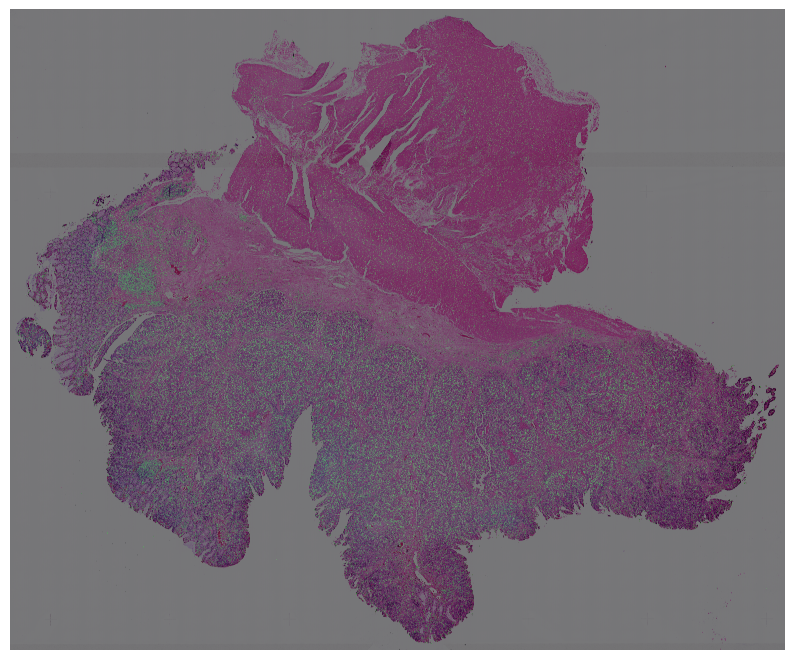

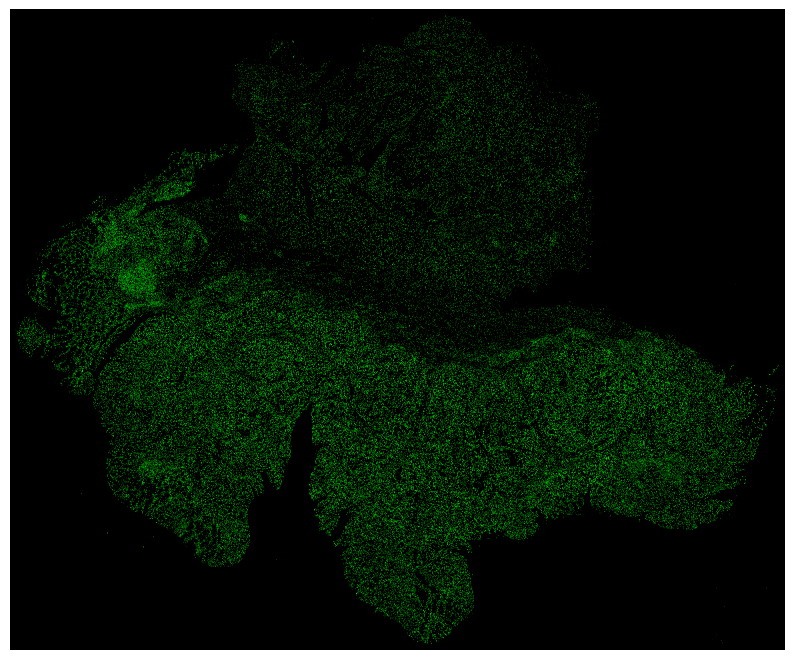

In [63]:
import tifffile as tiff
labels_npz_path = '/ix1/wchen/Zhaochongyue/spatial/crc_labels.npz'
# Load the saved npz file
cell_data = scipy.sparse.load_npz(labels_npz_path)
labels = cell_data.toarray()
def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = '/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/Visium_HD_Human_Colon_Cancer_P1_tissue_image.btf'
    print(os.path.exists(img_fold))
    img_color = tiff.imread(img_fold).astype(np.float32)
    img_color=img_color[:,:,0:3]
    #print(img_color.shape,'shape')
    # img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    #print(img_color.shape,'shape1')
    return img_color
names = ['P1_CRC']
# print(names[0])
image_rgb = get_img(names[0])
image_array = np.array(image_rgb)
def overlay_labels_on_image(image, labels):
    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image_rgb = (255 * (image - image.min()) / (image.max() - image.min())).astype(np.uint8)
    else:
        image_rgb = image.copy()

    # Create an RGB image if the input image is grayscale
    if len(image_rgb.shape) == 2 or image_rgb.shape[2] == 1:
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_GRAY2RGB)

    # Define green color for the masks
    green_color = np.array([0, 255, 0], dtype=np.uint8)

    # Create a mask where the labels are not zero
    mask = labels > 0

    # Apply the green color to the mask regions using vectorized operations
    overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    overlay[mask] = green_color

    # Blend the original image with the color overlay
    alpha = 0.5  # Transparency factor
    blended = cv2.addWeighted(image_rgb, 1 - alpha, overlay, alpha, 0)

    return blended

# Example usage:
blended_image = overlay_labels_on_image(image_array, labels)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(blended_image)
plt.axis('off')
plt.savefig('/ix1/wchen/Zhaochongyue/spatial/crc/p1/image_segment.png', bbox_inches='tight', dpi=600,pad_inches=0)
plt.show()
def plot_masks_only(labels):
    # Create an RGB image with a black background
    mask_rgb = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)

    # Define green color for the masks
    green_color = [0, 255, 0]

    # Apply the green color to the mask regions using vectorized operations
    mask_rgb[labels > 0] = green_color

    return mask_rgb

# Example usage:
mask_image = plot_masks_only(labels)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(mask_image)
plt.axis('off')
plt.savefig('/ix1/wchen/Zhaochongyue/spatial/crc/p1/image_segment1.png', bbox_inches='tight',  dpi=600,pad_inches=0)
plt.show()



In [29]:
names = ['P1_CRC']
all_centroids = []  # List to store all centroids
all_images = []  # List to store all images
all_labels_original = []
for name in names:
    image_org = get_img(name)
    # image,shift_image=crop_to_divisible_dimension(image_org)
    patch_size = [100, 100]
    img_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)


True


NameError: name 'image' is not defined

In [64]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original -> Encoded):")
print(label_mapping)

# Get unique encoded values
unique_encoded_labels = label_encoder.transform(label_encoder.classes_)
print("Unique Encoded Labels:")
print(unique_encoded_labels)

# Get unique original labels
unique_original_labels = label_encoder.classes_
print("Unique Original Labels:")
print(unique_original_labels)

Label Mapping (Original -> Encoded):
{'Adipocyte': 0, 'CAF': 1, 'CD4 T cell': 2, 'CD8 Cytotoxic T cell': 3, 'Endothelial': 4, 'Enteric Glial': 5, 'Enterocyte': 6, 'Epithelial': 7, 'Fibroblast': 8, 'Goblet': 9, 'Lymphatic Endothelial': 10, 'Macrophage': 11, 'Mast': 12, 'Mature B': 13, 'Myofibroblast': 14, 'Neuroendocrine': 15, 'Neutrophil': 16, 'Pericytes': 17, 'Plasma': 18, 'Proliferating Immune II': 19, 'SM Stress Response': 20, 'Smooth Muscle': 21, 'Tuft': 22, 'Tumor I': 23, 'Tumor II': 24, 'Tumor III': 25, 'Tumor V': 26, 'Unknown III (SM)': 27, 'mRegDC': 28, 'pDC': 29, 'vSM': 30}
Unique Encoded Labels:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Unique Original Labels:
['Adipocyte' 'CAF' 'CD4 T cell' 'CD8 Cytotoxic T cell' 'Endothelial'
 'Enteric Glial' 'Enterocyte' 'Epithelial' 'Fibroblast' 'Goblet'
 'Lymphatic Endothelial' 'Macrophage' 'Mast' 'Mature B' 'Myofibroblast'
 'Neuroendocrine' 'Neutrophil' 'Pericytes' 'Plasma'
 'Prolife

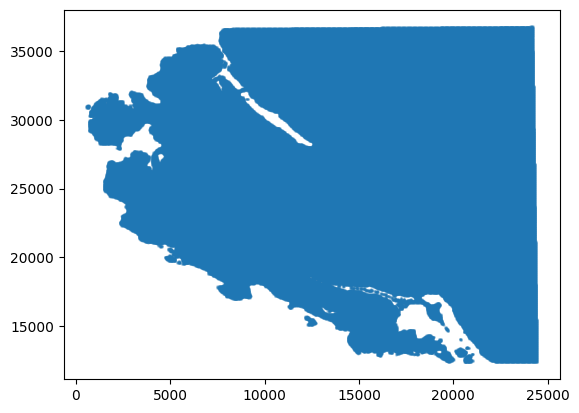

In [33]:
coords = spatial_coords_tensor.numpy()
spots_df1 = pd.DataFrame(coords, columns=['x', 'y'])
xI = np.array(spots_df1['x'])
yI = np.array(spots_df1['y'])

# plot
fig,ax = plt.subplots()
ax.scatter(yI,xI,s=1,alpha=0.2)
#ax.set_aspect('equal', 'box')

In [88]:
import sys
import re
import numpy as np
import pandas as pd
import scanpy as sc

def adjust_temperature(probs, temperature):
    logits = np.log(probs)
    logits /= temperature
    probs = np.exp(logits)
    probs = probs / probs.sum(-1, keepdims=True)
    return probs

def sample_from_scores(x, temperature=0.05):
    probs_raw = x / x.sum(-1, keepdims=True)
    probs = adjust_temperature(probs_raw, temperature=temperature)
    z = np.random.rand(*probs.shape[:-1], 1)
    threshs = np.cumsum(probs, -1)
    labels = (z > threshs).sum(-1)
    return labels
def get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df):
    df = marker_file_df[['gene', 'label']]
    labels = np.sort(df['label'].unique()).tolist()
    scores = []
    for lab in labels:
        marker_genes = df[df['label'] == lab]['gene'].values
        # Find indices of marker genes in the final_gene_list
        marker_indices = [i for i, gene in enumerate(final_gene_list) if gene in marker_genes]
        if marker_indices:
            # Sum the expression levels of the marker genes for each cell
            marker_scores = cell_by_gene_matrix[:, marker_indices].sum(axis=1)
        else:
            # If no marker genes are found for a label, use zero scores
            marker_scores = np.zeros(cell_by_gene_matrix.shape[0])
        scores.append(marker_scores)
    scores = np.stack(scores, axis=-1)
    return scores, labels

def predict(scores, labels, most_interested_labels, threshold=0.05):
    most_interested_indices = [labels.index(label) for label in most_interested_labels]
    
    # Compute confidence for the most interested cell types
    most_interested_confidence = scores[:, most_interested_indices].max(axis=1)
    most_interested_label_indices = scores[:, most_interested_indices].argmax(axis=1)
    
    # Initial labels with -1 (unclassified)
    predicted_labels = np.full(most_interested_confidence.shape, -1)
    
    # Classify cells as one of the most interested cell types if they exceed the threshold
    predicted_labels[most_interested_confidence >= threshold] = [
        most_interested_indices[label] for label in most_interested_label_indices[most_interested_confidence >= threshold]
    ]
    
    # Mask for cells not classified as one of the most interested cell types
    remaining_mask = predicted_labels == -1
    
    # For remaining cells, classify based on the max score among all cell types
    remaining_scores = scores[remaining_mask]
    if remaining_scores.size > 0:
        remaining_confidence = remaining_scores.max(axis=-1)
        remaining_labels = remaining_scores.argmax(axis=-1)
    
        # Apply threshold to filter out low-confidence predictions for remaining cells
        remaining_labels[remaining_confidence < threshold] = -1
        
        # Assign remaining labels
        predicted_labels[remaining_mask] = remaining_labels
    
    return predicted_labels

threshold=0.8
# def main():
np.random.seed(0)
data = N_tensor.numpy()
coords = spatial_coords_tensor.numpy()
spots_df1 = pd.DataFrame(coords, columns=['x', 'y'])

adata_09 = sc.AnnData(X=data)

cell_by_gene_matrix = adata_09.X
gene_names = final_gene_list

most_interested_label=['CD4 T cell','CD8 Cytotoxic T cell','Macrophage','Mature B','CAF']
scores, labels_names = get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df)

# Predict labels with a threshold
predicted_indices = predict(scores, labels_names, most_interested_label, threshold=threshold)

# Create final prediction labels
predictions = np.array(["unclassified"] * cell_by_gene_matrix.shape[0], dtype=object)
for i, label_index in enumerate(predicted_indices):
    if label_index != -1:
        predictions[i] = labels_names[label_index]


True


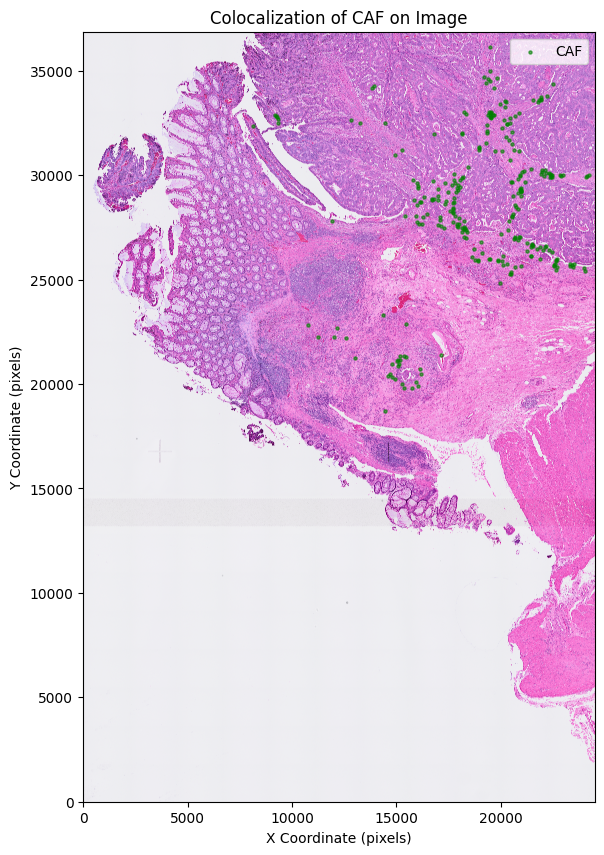

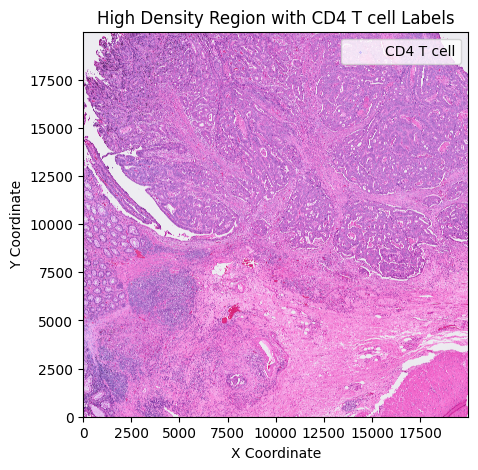

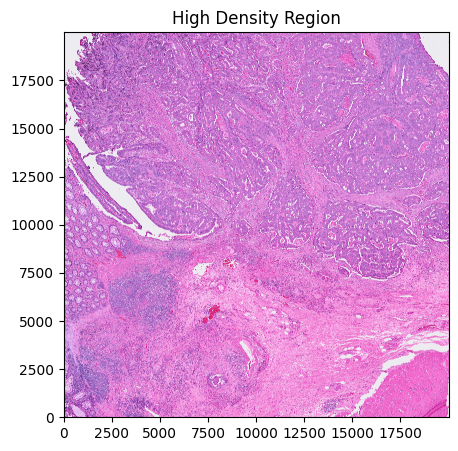

In [92]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tifffile as tiff
def plot_colocalization_and_find_highest_density_region(df, cell_type, image, sample_size=10000, min_points=10):
    # Filter the DataFrame to include only the specified cell type
    df_filtered = df[df['cell_type'] == cell_type]
    
    # Downsample if the dataset is too large
    if len(df_filtered) > sample_size:
        df_filtered = df_filtered.sample(sample_size)
     # Determine the bounding box of the cell type locations
    x_min, y_min = df_filtered[['x', 'y']].min() - margin
    x_max, y_max = df_filtered[['x', 'y']].max() + margin
    
    # Ensure the bounding box is within image bounds
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(image.shape[1], x_max)
    y_max = min(image.shape[0], y_max)
    
    # Extract the ROI from the image
    roi_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
     # Adjust the cell coordinates to the new ROI coordinate system
    x = df_filtered['x'].values - x_min
    y = df_filtered['y'].values - y_min
    plt.figure(figsize=(10, 5))
    
    # Plot the cell type
    if len(df_filtered) > min_points:
        x = df_filtered['x'].values
        y = df_filtered['y'].values
        
        # Scatter plot
        plt.scatter(x, y, color='blue', s=0.05, label=cell_type, alpha=0.6)
        
        # Adding density contours for the cell type
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy)
        
        # Create density grid for contour plotting
        xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
        zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
        
        # Plot contours
        plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, colors=['blue'], alpha=0.5)
        
        # Find the location with the highest density
        max_density_index = np.argmax(zi)
        max_density_coords = np.unravel_index(max_density_index, xi.shape)
        highest_density_point = (xi[max_density_coords], yi[max_density_coords])
        
        plt.scatter(highest_density_point[0], highest_density_point[1], color='red', s=100, label='Highest Density', marker='X')
        
        plt.title(f'Colocalization of {cell_type}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.legend()
        plt.show()
        
        return highest_density_point, (xi, yi, zi)
    else:
        print(f"Not enough points to perform KDE for cell type: {cell_type}")
        return None, None

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_density_on_image(df, cell_type, image, microns_per_pixel, sample_size=1000000, min_points=10, margin=50):
    """
    Plots the density of a specific cell type on a given image, using the maximum x and y 
    coordinates across all cell types to determine the region of interest.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing cell data with 'x', 'y', and 'cell_type' columns.
    - cell_type (str): The cell type to analyze.
    - image (np.array): The high-resolution image to be used as the background.
    - microns_per_pixel (float): The conversion factor from microns to pixels.
    - sample_size (int): Maximum number of points to use for KDE to avoid performance issues.
    - min_points (int): Minimum number of points required to perform KDE.
    - margin (int): Distance to extend beyond the bounding box of the cells for plotting.
    
    Returns:
    - highest_density_point (tuple): Coordinates of the highest density region.
    - density_grid (tuple): Grid coordinates and density values (xi, yi, zi).
    """
    
    # Determine the overall bounding box using the max values from the entire DataFrame (all cell types)
    x_min = df['x'].min()  # Use the minimum x value across all cell types
    x_max = df['x'].max() + margin
    y_min = df['y'].min()  # Use the minimum y value across all cell types
    y_max = df['y'].max() + margin
    
    # Ensure the bounding box is within image bounds
    # x_max = min(image.shape[1], x_max)
    # y_max = min(image.shape[0], y_max)
    
    # Crop the image using the determined bounding box
    cropped_image = image[0:int(x_max), 0:int(y_max)]
    
    # Filter the DataFrame to include only the specified cell type
    df_filtered = df[df['cell_type'] == cell_type]
    
    # Check if there are enough points for KDE
    if len(df_filtered) < min_points:
        print(f"Not enough points to perform KDE for cell type: {cell_type}")
        return None, None
    
    # Use the original coordinates for scaling
    df_filtered['x_scaled'] = df_filtered['x']
    df_filtered['y_scaled'] = df_filtered['y']
    
    # Adjust the cell coordinates relative to the new ROI coordinate system
    x = df_filtered['x_scaled'].values
    y = df_filtered['y_scaled'].values 
    
    # Prepare the plot
    plt.figure(figsize=(10, 10))
    
    # Display the cropped image
    plt.imshow(cropped_image, origin='lower')
    
    # Scatter plot of the cell type
    plt.scatter(y, x, color='green', s=5, label=cell_type, alpha=0.6)
    
    # KDE for density estimation
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    
    # Create a grid for contour plotting within the ROI
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
    
    # Plot density contours
    # plt.contour(yi, xi, zi.reshape(xi.shape), levels=10, colors=['red'], alpha=0.5)
    
    # Find the location with the highest density
    max_density_index = np.argmax(zi)
    max_density_coords = np.unravel_index(max_density_index, xi.shape)
    highest_density_point = (yi[max_density_coords], xi[max_density_coords])
    
    # Mark the highest density point
    # plt.scatter(highest_density_point[0], highest_density_point[1], color='yellow', s=100, label='Highest Density', marker='X')
    
    # Final plot details
    plt.title(f'Colocalization of {cell_type} on Image')
    plt.xlabel('X Coordinate (pixels)')
    plt.ylabel('Y Coordinate (pixels)')
    plt.legend()
    plt.savefig(f'/ix1/wchen/Zhaochongyue/spatial/crc/p1/{cell_type}_spot.png', bbox_inches='tight',dpi=600, pad_inches=0)
    plt.show()
    
    return highest_density_point, (xi, yi, zi)


def cut_high_density_region(image, highest_density_point, image_extent, region_size=20000):
    x, y = highest_density_point
    
    # Transform the coordinates to pixel indices
    # x_pixel = int((x - image_extent[0]) / (image_extent[1] - image_extent[0]) * image.shape[1])
    # y_pixel = int((y - image_extent[2]) / (image_extent[3] - image_extent[2]) * image.shape[0])
    # rotated_image = np.flipud(image)
    # Calculate the boundaries of the region to cut
    x_min = int(max(x - region_size // 2, 0))
    x_max = int(min(x + region_size // 2, image.shape[1]))
    y_min = int(max(y - region_size // 2, 0))
    y_max = int(min(y + region_size // 2, image.shape[0]))
    
    # Cut the region from the image
    cut_region = image[y_min:y_max, x_min:x_max]
    
    return cut_region, (x_min, x_max, y_min, y_max)
def plot_cut_region_with_labels(df, cut_region, cut_bounds, cell_type, original_image_extent,image):
    x_min, x_max, y_min, y_max = cut_bounds
    
    # Filter the DataFrame to include only the specified cell type and the coordinates within the cut region
    df_filtered = df[(df['cell_type'] == cell_type) & 
                     (df['x'] >= x_min) &
                     (df['x'] <= x_max) &
                     (df['y'] >= y_min)&
                     (df['y'] <=y_max)]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cut_region, origin='lower')
    
    # x_scaled = (df_filtered['x'].values - original_image_extent[0]) / (original_image_extent[1] - original_image_extent[0]) * image.shape[1]
    # y_scaled = (df_filtered['y'].values - original_image_extent[2]) / (original_image_extent[3] - original_image_extent[2]) * image.shape[0]
    x_cut=df_filtered['x']-x_min
    y_cut=df_filtered['y']-y_min
    plt.scatter(y_cut, x_cut, color='blue', s=0.05, label=cell_type, alpha=0.6)
    
    plt.title(f'High Density Region with {cell_type} Labels')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()
data = N_tensor.numpy()
coords = spatial_coords_tensor.numpy()
spots_df1 = pd.DataFrame(coords, columns=['x', 'y'])

# Step 1: Initial classification of spots
# predictions = classify_spots(data, model_classification, device)
y = adata_sc.obs['Level2'].values 
spots_df1['cell_type'] = predictions

def get_img(name):
    if name in ['A1', 'A2', 'A3','A4']:
        img_fold = os.path.join('/ix1/wchen/Zhaochongyue/spatial/Lung/ST/', name,
                                'outs/spatial/full_image.tif')
    elif name=='08_WT_F_S':
        name='08_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    elif name=='09_WT_F_S':
        name='09_WT_F-S'
        img_fold = os.path.join('/ix1/wchen/Shiyue/Projects/2023_06_Influ_Mouse_Lung_ST/RawData/Fastq/Alcorn_Visium_FFPE_Images/', name + '.TIF')
    else:
        img_fold = '/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/Visium_HD_Human_Colon_Cancer_P1_tissue_image.btf'
    print(os.path.exists(img_fold))
    img_color = tiff.imread(img_fold).astype(np.float32)
    img_color=img_color[:,:,0:3]

    return img_color
names = ['P1_CRC']
# print(names[0])
image_rgb = get_img(names[0])
image_array = np.array(image_rgb)
microns_per_pixel =0.27380817798463214

highest_density_point, density_data = plot_density_on_image(spots_df1, 'CAF', image_array/255,microns_per_pixel)
if highest_density_point:
    image_extent = [spots_df1['x'].min(), spots_df1['x'].max(), spots_df1['y'].min(), spots_df1['y'].max()]
    cut_region, cut_bounds = cut_high_density_region(image_array/255, highest_density_point, image_extent)
    plot_cut_region_with_labels(spots_df1, cut_region, cut_bounds, 'CD4 T cell', image_extent,image_array/255)
    # print(cut_region.shape)
    plt.figure(figsize=(5, 5))
    # plt.imshow(cut_region,origin='lower')
    plt.title('High Density Region')
    plt.show()

Index(['barcode', 'DeconvolutionClass', 'DeconvolutionLabel1',
       'DeconvolutionLabel2', 'in_tissue', 'array_row', 'array_col',
       'pxl_row_in_fullres', 'pxl_col_in_fullres'],
      dtype='object')


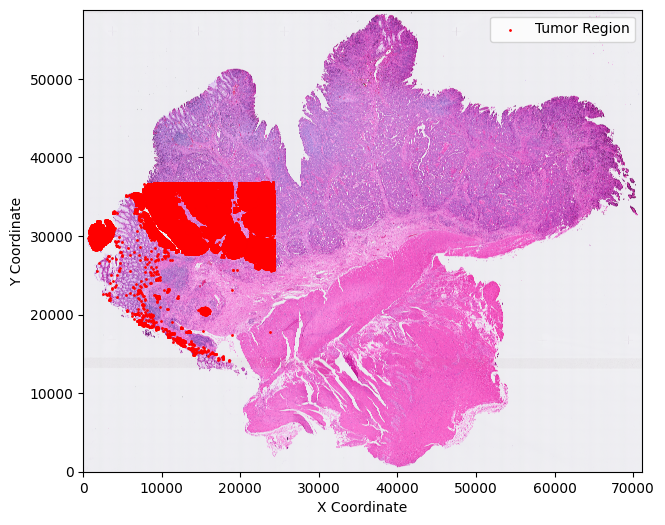

In [25]:
input_dir = os.path.join('/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/HD/P1_CRC/binned_outputs/', 'square_008um/')
    
file_Adj = os.path.join(input_dir, "spatial/tissue_positions.parquet")
metadata = pd.read_csv("/ix1/wchen/liutianhao/result/lung_ST/crc/DeconvolutionResults_P1CRC.csv")
positions = pd.read_parquet(file_Adj)
# Step 2: Extract spatial coordinates from adata.obsm['spatial'] using barcode
# Assuming `adata.obsm['spatial']` is a NumPy array and `adata.obs['barcode']` matches metadata['barcode']
merged_data = pd.merge(metadata, positions, on='barcode', how='inner')

# Step 4: Assuming the positions DataFrame contains spatial information like 'x' and 'y'
# Check if positions have 'x', 'y' coordinates
print(merged_data.columns)  # This will show the columns to confirm the spatial coordinates are there

# Step 5: Filter for tumor regions using DeconvolutionLabel1 (or whatever label is used for filtering)
tumor_metadata = merged_data[
    (merged_data['DeconvolutionLabel1'] == 'Tumor II')
]
plt.figure(figsize=(8, 6))
plt.imshow(image_array/255, origin='lower')
plt.scatter(tumor_metadata['pxl_col_in_fullres'], tumor_metadata['pxl_row_in_fullres'], color='red', label='Tumor Region', s=1)

# plt.title("Tumor Regions Based on DeconvolutionLabel")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.savefig('/ix1/wchen/Zhaochongyue/spatial/crc/p1/Tumor_region.png', bbox_inches='tight',dpi=600, pad_inches=0)
plt.show()


In [37]:
metadata = pd.read_csv("/ix1/wchen/liutianhao/result/lung_ST/crc/DeconvolutionResults_P1CRC.csv", delimiter=',')
metadata

barcode DeconvolutionClass DeconvolutionLabel1  \
0       s_008um_00000_00000-1                NaN                 NaN   
1       s_008um_00000_00001-1                NaN                 NaN   
2       s_008um_00000_00002-1                NaN                 NaN   
3       s_008um_00000_00003-1                NaN                 NaN   
4       s_008um_00000_00004-1                NaN                 NaN   
...                       ...                ...                 ...   
702239  s_008um_00837_00833-1                NaN                 NaN   
702240  s_008um_00837_00834-1                NaN                 NaN   
702241  s_008um_00837_00835-1                NaN                 NaN   
702242  s_008um_00837_00836-1                NaN                 NaN   
702243  s_008um_00837_00837-1                NaN                 NaN   

       DeconvolutionLabel2  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
702239                 NaN  
702240                 NaN  
702241                 NaN  
702242                 NaN  
702243                 NaN  

[702244 rows x 4 columns]

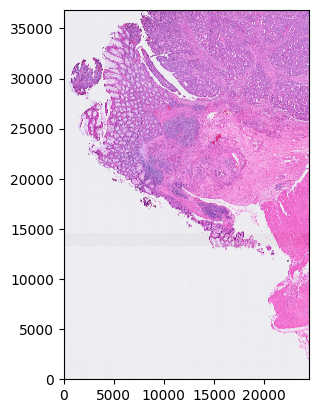

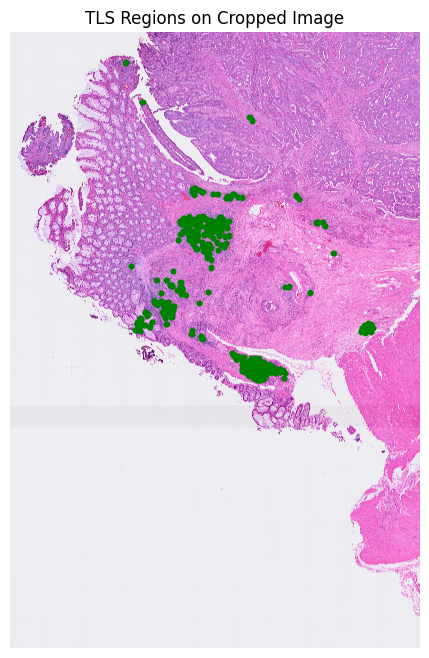

In [32]:
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import cKDTree
# from scipy.spatial import cKDTree  # For fast neighbor search
# import torch
# import matplotlib.pyplot as plt

def plot_tls_on_cropped_image(image, spots_df1, data_N, final_gene_list, marker_list, tumor_metadata, threshold=0.1, minimum_markers_required=2, margin=10, neighbor_distance=100):
    """
    Identify TLS regions and plot them on a cropped image based on proximity to tumor locations.
    
    Parameters:
    - spots_df1: DataFrame containing 'x' and 'y' coordinates of spatial locations.
    - data_N: 2D PyTorch tensor where rows are spatial locations and columns are genes (already normalized).
    - final_gene_list: List of gene names corresponding to the columns in data_N.
    - marker_list: List of marker genes to define TLS regions.
    - image: Original image to be cropped and used as background.
    - tumor_metadata: DataFrame with tumor 'x' and 'y' coordinates.
    - threshold: Expression threshold to consider a marker as 'present'.
    - minimum_markers_required: Minimum number of markers required to define a TLS region.
    - margin: Additional margin to include around the detected bounding box.
    - neighbor_distance: Maximum distance to consider a spatial location as a neighbor to tumor regions.
    """
    
    # Step 1: Filter marker genes present in the dataset
    marker_genes = [gene for gene in marker_list if gene in final_gene_list]

    # Step 2: Initialize a binary tensor to store whether each marker gene is above the threshold
    binary_scores = torch.zeros((data_N.shape[0], len(marker_genes)), dtype=torch.int32)

    # Apply the threshold to each marker gene
    for i, gene in enumerate(marker_genes):
        gene_index = final_gene_list.index(gene)
        binary_scores[:, i] = (data_N[:, gene_index] >= threshold).int()

    # Step 3: Sum the binary scores across all markers to get the TLS score for each spatial location
    tls_score = torch.sum(binary_scores, dim=1)

    # Define TLS regions based on the minimum number of markers required
    tls_region = (tls_score >= minimum_markers_required).int()

    # Step 4: Get TLS coordinates
    tls_region_np = tls_region.bool().numpy()

# Now use this NumPy array to index spots_df1
    tls_coords = spots_df1.loc[tls_region_np, ['x', 'y']].values  # Coordinates of the TLS regions
    tumor_coords = tumor_metadata[['pxl_row_in_fullres', 'pxl_col_in_fullres']].values  # Tumor locations

    # Step 5: Use KDTree for fast neighbor search within the given neighbor distance
    kdtree = cKDTree(spots_df1[['x', 'y']].values)  # KDTree of all spot coordinates
    neighbor_indices = kdtree.query_ball_point(tumor_coords, r=neighbor_distance)  # Indices of spots near tumors

    # Flatten the list of neighbor indices
    neighbor_indices_flat = set([idx for sublist in neighbor_indices for idx in sublist])

    # Step 6: Filter TLS regions that are within neighbor_distance of any tumor location
    tls_neighbor_coords = spots_df1.iloc[list(neighbor_indices_flat)][['x', 'y']]

    # Step 7: Determine the bounding box for cropping the image based on TLS neighbors
    x_min = max(0, tls_neighbor_coords['x'].min() - margin)
    x_max = min(image.shape[1], tls_neighbor_coords['x'].max() + margin)
    y_min = max(0, tls_neighbor_coords['y'].min() - margin)
    y_max = min(image.shape[0], tls_neighbor_coords['y'].max() + margin)

    # Step 8: Crop the image using the determined bounding box
    cropped_image = image[0:int(x_max), 0:int(y_max)]
    plt.imshow(cropped_image, origin='lower')

    # Plot TLS regions within neighbor distance of tumors
    plt.scatter(tls_neighbor_coords['y'], tls_neighbor_coords['x'], color='green', s=10, label='TLS Region (within 100 units)')

    # Plot tumor locations
    # plt.scatter(tumor_metadata['pxl_col_in_fullres'], tumor_metadata['pxl_row_in_fullres'], color='red', marker='x', s=10, label='Tumor Location')

    plt.title('TLS Regions Within 100 Units of Tumor Locations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

def plot_tls_on_cropped_image1(image,spots_df1, data_N, final_gene_list, marker_list, threshold=0.1, minimum_markers_required=2, margin=10):
    """
    Identify TLS regions and plot them on a cropped image based on the bounding box.
    
    Parameters:
    - spots_df1: DataFrame containing 'x' and 'y' coordinates of spatial locations.
    - data_N: 2D PyTorch tensor where rows are spatial locations and columns are genes (already normalized).
    - final_gene_list: List of gene names corresponding to the columns in data_N.
    - marker_list: List of marker genes to define TLS regions.
    - image: Original image to be cropped and used as background.
    - threshold: Expression threshold to consider a marker as 'present'.
    - minimum_markers_required: Minimum number of markers required to define a TLS region.
    - margin: Additional margin to include around the detected bounding box.
    """
    # Filter marker genes present in the dataset
    marker_genes = [gene for gene in marker_list if gene in final_gene_list]

    # Initialize a binary tensor to store whether each marker gene is above the threshold
    binary_scores = torch.zeros((data_N.shape[0], len(marker_genes)), dtype=torch.int32)

    # Apply the threshold to each marker gene
    for i, gene in enumerate(marker_genes):
        gene_index = final_gene_list.index(gene)
        binary_scores[:, i] = (data_N[:, gene_index] >= threshold).int()

    # Sum the binary scores across all markers to get the TLS score for each spatial location
    tls_score = torch.sum(binary_scores, dim=1)

    # Define TLS regions based on the minimum number of markers required
    tls_region = (tls_score >= minimum_markers_required).int()

    # Determine the overall bounding box using the max values from the entire DataFrame (all cell types)
    x_min = spots_df1['x'].min()
    x_max = spots_df1['x'].max() + margin
    y_min = spots_df1['y'].min()
    y_max = spots_df1['y'].max() + margin

    # Ensure the bounding box is within image bounds
    # x_max = min(image.shape[1], x_max)
    # y_max = min(image.shape[0], y_max)

    # Crop the image using the determined bounding box
    cropped_image = image[0:int(x_max), 0:int(y_max)]
    plt.imshow(cropped_image, origin='lower')
    # Convert 'x' and 'y' coordinates from Pandas Series to PyTorch tensors
    x_coords = torch.tensor(spots_df1['x'].values).long()
    y_coords = torch.tensor(spots_df1['y'].values).long()
    coords = np.vstack((x_coords[tls_region.bool()].numpy(), y_coords[tls_region.bool()].numpy())).T
    clustering = DBSCAN(eps=30, min_samples=2).fit(coords)

    # Filter the TLS regions based on the clustering result
    clustered_tls_x = coords[clustering.labels_ != -1][:, 0]
    clustered_tls_y = coords[clustering.labels_ != -1][:, 1]
    # Create a grid to visualize the TLS regions within the bounding box
    grid = torch.full((int(x_max)+1, int(y_max)+1), torch.nan, dtype=torch.float32)
    adjusted_x_coords = x_coords
    adjusted_y_coords = y_coords
    # grid[adjusted_x_coords, adjusted_y_coords] = tls_region.float()

    # Convert the grid to a NumPy array for visualization
    # grid_np = grid.cpu().numpy()

    plt.figure(figsize=(10, 8))
    plt.imshow(cropped_image, origin='lower')
    tls_x_coords = x_coords[tls_region.bool()]
    tls_y_coords = y_coords[tls_region.bool()]

    plt.scatter(clustered_tls_y, clustered_tls_x, color='green', s=10, label='TLS Region')  # Large green dots

    # plt.imshow(grid_np, cmap='Oranges', interpolation='nearest', alpha=0.5)  # Overlay the grid
    # plt.colorbar(label='TLS Presence')
    plt.title('TLS Regions on Cropped Image')
    plt.axis('off')  # Hide axes
    plt.savefig('/ix1/wchen/Zhaochongyue/spatial/crc/p1/tls_crc_p1.png', bbox_inches='tight', dpi=600)
    plt.show()
    
    # else:
        # print("No TLS regions detected.")
# CETP,ENSG00000087237,Gene Expression
# Untitled List,CCR7,ENSG00000126353,Gene Expression
# Untitled List,SELL,ENSG00000188404,Gene Expression
# Untitled List,CXCL13,ENSG00000156234,Gene Expression
# Untitled List,LAMP3,ENSG00000078081,Gene Expression
# Untitled List,CCL19,ENSG00000172724,Gene Expression
# Untitled List,MS4A1

# Example usage:
marker_list=['CETP','SELL','CXCL13','LAMP3','CCL19','MS4A1']
# marker_list = ['CXCL13', 'CCL19', 'CCL21', 'CCR7', 'CXCR5', 'LAMP3', 'CD3', 'CD8', 'MS4A1', 'SELL', 'BCL6', 'PDPN', 'ICOS', 'FDCSP']
# Assume `spots_df1`, `N_tensor` (PyTorch tensor), `final_gene_list`, and `image` are already defined
plot_tls_on_cropped_image1(image_array/255,spots_df1, N_tensor, final_gene_list, marker_list, threshold=0.1, minimum_markers_required=2, margin=50)



In [ ]:
x_min = spots_df1['x'].min()
x_max = spots_df1['x'].max() + 50
y_min = spots_df1['y'].min()
y_max = spots_df1['y'].max() + 50
image1=image_array/255
    # Ensure the bounding box is within image bounds
    # x_max = min(image.shape[1], x_max)
    # y_max = min(image.shape[0], y_max)

    # Crop the image using the determined bounding box
cropped_image = image1[0:int(x_max), 0:int(y_max)]
plt.imshow(cropped_image, origin='lower')

In [ ]:
Untitled List,CETP,ENSG00000087237,Gene Expression
Untitled List,CCR7,ENSG00000126353,Gene Expression
Untitled List,SELL,ENSG00000188404,Gene Expression
Untitled List,CXCL13,ENSG00000156234,Gene Expression
Untitled List,LAMP3,ENSG00000078081,Gene Expression
Untitled List,CCL19,ENSG00000172724,Gene Expression
Untitled List,MS4A1,ENSG00000156738,Gene Expression

In [ ]:
# print(highest_density_point.shape)
highest_density_point,image_array.shape,cut_region[50,9,2]

In [ ]:
filtered_df = spots_df1[spots_df1['cell_type'] == 'Club_cell']
filtered_df

In [37]:
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.ndimage import center_of_mass
from skimage.measure import regionprops
coords = spatial_coords_tensor.numpy()
def get_cell_boundaries_and_centers(binary_mask):
    """
    Get cell boundaries and centers from a binary segmentation mask.

    Parameters:
    binary_mask (np.ndarray): 2D array where each cell region has a value of 1.

    Returns:
    list: A list of dictionaries containing cell boundaries and centers.
    """
    # Label connected components in the binary mask
    labelled_mask, num_features = label(binary_mask,return_num=True)
    
    # Get cell boundaries and centers
    centers = center_of_mass(binary_mask, labelled_mask, np.arange(1, num_features + 1))
    print('True')
    props = regionprops(labelled_mask)
    
    cell_info = [
        {
            'boundaries': np.column_stack(np.where(find_boundaries((labelled_mask == prop.label), mode='inner'))),
            'center': center
        }
        for prop, center in zip(props, centers)
    ]

    return cell_info
def get_cell_centers(binary_mask, coords):
    """
    Get cell centers from a binary segmentation mask and filter by coordinates.

    Parameters:
    binary_mask (np.ndarray): 2D array where each cell region has a value of 1.
    coords (tuple): A tuple of (min_row, max_row, min_col, max_col) to filter the cell centers.

    Returns:
    np.ndarray: Array of filtered cell centers (row, col) format.
    np.ndarray: Labelled mask with connected components, in the original coordinates.
    """
    min_row = int(np.min(coords[:, 0]))
    max_row = int(np.max(coords[:, 0]))
    min_col = int(np.min(coords[:, 1]))
    max_col = int(np.max(coords[:, 1]))


    # Filter the binary mask by the provided coordinates
    filtered_mask = binary_mask[min_row:max_row + 1, min_col:max_col + 1]

    # Label connected components in the filtered binary mask
    labelled_mask, num_features = label(filtered_mask, return_num=True)
    
    # Get cell centers
    centers = center_of_mass(filtered_mask, labelled_mask, np.arange(1, num_features + 1))

    # Adjust centers to the original coordinate system
    adjusted_centers = [(center[0] + min_row, center[1] + min_col) for center in centers]

    # Create a full-size labelled mask and place the filtered labelled mask within it
    full_labelled_mask = np.zeros_like(binary_mask, dtype=int)
    full_labelled_mask[min_row:max_row + 1, min_col:max_col + 1] = labelled_mask

    return np.array(adjusted_centers), full_labelled_mask
cells_info,labelled_mask = get_cell_centers(labels,coords)

def assign_spots_to_cells_new(coords, labelled_mask, bin_size):
    """
    Assign spots to cells based on the cell mask region.

    Parameters:
    coords (np.ndarray): Array of coordinates for the spots.
    labelled_mask (np.ndarray): 2D array where each cell has a unique integer ID.
    bin_size (int): Size of the bin to check overlap with the mask.

    Returns:
    dict: Dictionary mapping cell indices to their respective spot indices.
    """
    spot_to_cell = {i: [] for i in np.unique(labelled_mask) if i > 0}

    for j, (y_center,x_center) in enumerate(coords):
        x_min = max(0, int(x_center - bin_size // 2))
        x_max = min(labelled_mask.shape[1], int(x_center + bin_size // 2))
        y_min = max(0, int(y_center - bin_size // 2))
        y_max = min(labelled_mask.shape[0], int(y_center + bin_size // 2))
        
        cell_region = labelled_mask[y_min:y_max, x_min:x_max]
        
        # Get the unique cell IDs within this region
        unique_cells = np.unique(cell_region[cell_region > 0])
        
        # Assign the spot to each of the cells it overlaps with
        for cell_id in unique_cells:
            spot_to_cell[cell_id].append(j)
    spot_to_cell = {cell_id: spots for cell_id, spots in spot_to_cell.items() if spots}
    return spot_to_cell
bin_size = 16  # Example bin size
data = N_tensor.numpy()
coords = spatial_coords_tensor.numpy()
spot_to_cell = assign_spots_to_cells_new(coords, labelled_mask, bin_size)

In [38]:
def construct_graph_with_distance_threshold(num_nodes, coords, distance_threshold):
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            distance = np.linalg.norm(coords[i] - coords[j])
            if distance < distance_threshold:
                edges.append((i, j))
                edges.append((j, i))
    return edges
from collections import Counter
def build_graph_with_labels_and_threshold(spot_to_cell, coords, data,  distance_threshold):
    cells_data = []
    cell_centers = {}
    unique_labels = sorted(set(predictions))  # Get unique labels and sort them
    print(unique_labels)
    label_counts = Counter(predictions)
    for label in unique_labels:
        print(f"Label: {label}, Count: {label_counts[label]}")
    label_to_num = {label: idx for idx, label in enumerate(unique_labels)}
    num_to_label = {idx: label for label, idx in label_to_num.items()}  # Reverse mapping for reference

    for cell_id, spot_indices in spot_to_cell.items():
        cell_spots = data[spot_indices]
        cell_coords = coords[spot_indices]
        cell_labels = [label_to_num[label] for label in predictions[spot_indices]]  # Convert labels to numeric
        # cell_labels = predictions[spot_indices]
        local_indices = list(range(len(spot_indices)))
        if len(local_indices) == 1:
            edges = [(0, 0)]  # Add a self-loop for a single spot
        else:
            edges = construct_graph_with_distance_threshold(len(local_indices), cell_coords, distance_threshold)
        if len(edges) == 0:
            print(f"No edges constructed for cell {cell_id} with spots {spot_indices}")
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(cell_spots, dtype=torch.float)
        y = torch.tensor(cell_labels, dtype=torch.long)
        data_obj = Data(x=x, edge_index=edge_index,y=y)
        data_obj.cell_id = cell_id  # Add cell ID to the data object
        cells_data.append(data_obj)
        
        # Compute and store the cell center
        center_y, center_x = cell_coords.mean(axis=0)
        cell_centers[cell_id] = (center_x, center_y)
    return cells_data, cell_centers,label_to_num, num_to_label
        # cells_data.append(Data(x=x, edge_index=edge_index, y=y))
    # return cells_data
distance_threshold = 100  # Example distance threshold

cells_data,cell_centers,label_to_num, num_to_label = build_graph_with_labels_and_threshold(spot_to_cell, coords, data, distance_threshold)

['Adipocyte', 'CAF', 'CD4 T cell', 'CD8 Cytotoxic T cell', 'Endothelial', 'Enteric Glial', 'Enterocyte', 'Fibroblast', 'Goblet', 'Lymphatic Endothelial', 'Macrophage', 'Mast', 'Mature B', 'Myofibroblast', 'Neuroendocrine', 'Neutrophil', 'Pericytes', 'Plasma', 'Proliferating Immune II', 'SM Stress Response', 'Smooth Muscle', 'Tuft', 'Tumor I', 'Tumor II', 'Tumor III', 'Tumor V', 'Unknown III (SM)', 'mRegDC', 'pDC', 'unclassified', 'vSM']
Label: Adipocyte, Count: 1980
Label: CAF, Count: 33144
Label: CD4 T cell, Count: 8301
Label: CD8 Cytotoxic T cell, Count: 3780
Label: Endothelial, Count: 8013
Label: Enteric Glial, Count: 2239
Label: Enterocyte, Count: 5945
Label: Fibroblast, Count: 7738
Label: Goblet, Count: 18398
Label: Lymphatic Endothelial, Count: 6448
Label: Macrophage, Count: 18067
Label: Mast, Count: 4358
Label: Mature B, Count: 4913
Label: Myofibroblast, Count: 6320
Label: Neuroendocrine, Count: 3455
Label: Neutrophil, Count: 5393
Label: Pericytes, Count: 6642
Label: Plasma, Cou

In [39]:
import sys
import re
import numpy as np
import pandas as pd
import scanpy as sc

def adjust_temperature(probs, temperature):
    logits = np.log(probs)
    logits /= temperature
    probs = np.exp(logits)
    probs = probs / probs.sum(-1, keepdims=True)
    return probs

def sample_from_scores(x, temperature=0.05):
    probs_raw = x / x.sum(-1, keepdims=True)
    probs = adjust_temperature(probs_raw, temperature=temperature)
    z = np.random.rand(*probs.shape[:-1], 1)
    threshs = np.cumsum(probs, -1)
    labels = (z > threshs).sum(-1)
    return labels

def get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df):
    df = marker_file_df
    df = df[['gene', 'label']]
    labels = np.sort(df['label'].unique()).tolist()
    scores = []
    for lab in labels:
        marker_genes = df[df['label'] == lab]['gene'].values
        # Find indices of marker genes in the final_gene_list
        marker_indices = [i for i, gene in enumerate(final_gene_list) if gene in marker_genes]
        # Sum the expression levels of the marker genes for each cell
        marker_scores = cell_by_gene_matrix[:,marker_indices].sum(axis=1)
        scores.append(marker_scores)
    scores = np.stack(scores, axis=-1)
    return scores, labels

def predict(scores, threshold=0.05, sample=False):
    mask = np.isfinite(scores).all(-1)
    if sample:
        labels = sample_from_scores(scores, temperature=0.05)
    else:
        labels = np.full(mask.shape, -1)
        labels[mask] = scores[mask].argmax(-1)
    # Compute confidence as the maximum score
    confidence = scores.max(-1)
    # Apply threshold to filter out low-confidence predictions
    labels[confidence < threshold] = -1
    return labels

In [40]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import DataLoader as PyGDataLoader
from torch_geometric.nn import GATConv, global_max_pool
from torch_geometric.nn import GATConv, global_mean_pool
def predict1(scores, labels, most_interested_labels, threshold_1=0.1, threshold_2=0.1):
    most_interested_indices = [labels.index(label) for label in most_interested_labels]
    
    # Compute confidence for the most interested cell types
    most_interested_confidence = scores[:, most_interested_indices].max(axis=1)
    most_interested_label_indices = scores[:, most_interested_indices].argmax(axis=1)
    
    # Initial labels with -1 (unclassified)
    predicted_labels = np.full(most_interested_confidence.shape, -1)
    
    # Classify cells based on the thresholds: apply threshold_2 only for the second index, threshold_1 for the others
    for i, label_index in enumerate(most_interested_label_indices):
        if label_index == 2:  # For the second index in most_interested_labels
            if most_interested_confidence[i] >= threshold_1:
                predicted_labels[i] = most_interested_indices[label_index]
        else:  # For all other labels
            if most_interested_confidence[i] >= threshold_2:
                predicted_labels[i] = most_interested_indices[label_index]
    
    # Mask for cells not classified as one of the most interested cell types
    remaining_mask = predicted_labels == -1
    
    # For remaining cells, classify based on the max score among all cell types
    remaining_scores = scores[remaining_mask]
    if remaining_scores.size > 0:
        remaining_confidence = remaining_scores.max(axis=-1)
        remaining_labels = remaining_scores.argmax(axis=-1)
    
        # Apply threshold_1 for remaining cells (as a general fallback threshold)
        remaining_labels[remaining_confidence < threshold_1] = -1
        
        # Assign remaining labels
        predicted_labels[remaining_mask] = remaining_labels
    
    return predicted_labels
class LabelAwareWeighting(nn.Module):
    def __init__(self, hidden_features, num_labels):
        super(LabelAwareWeighting, self).__init__()
        self.label_embedding = nn.Embedding(num_labels, hidden_features)
        self.fc = nn.Linear(hidden_features * 2, 1)
    
    def forward(self, x, node_labels):
        # Get label embeddings
        label_embeddings = self.label_embedding(node_labels)  # [num_nodes, hidden_features]
        
        # Concatenate node features with their corresponding label embeddings
        x_label_concat = torch.cat([x, label_embeddings], dim=1)  # [num_nodes, hidden_features * 2]
        
        # Compute the weight for each node
        node_weights = torch.sigmoid(self.fc(x_label_concat))  # [num_nodes, 1]
        
        return node_weights

class GraphAttentionModelWithSelectiveLabelHandling(nn.Module):
    def __init__(self, in_features, hidden_features, num_labels, out_features, specific_classes):
        super(GraphAttentionModelWithSelectiveLabelHandling, self).__init__()
        self.conv1 = GATConv(in_features, hidden_features, heads=8, concat=True)
        self.conv2 = GATConv(hidden_features * 8, hidden_features, heads=8, concat=True)
        
        self.fc_node_gene_expression = nn.Linear(hidden_features * 8, out_features)  # Node gene expression
        self.label_aware_weighting = LabelAwareWeighting(hidden_features * 8, num_labels)
        self.specific_classes = torch.tensor(specific_classes)  # Specific classes to check

    def forward(self, x, edge_index, node_labels):
        # Node feature extraction using GAT layers
        self.specific_classes = self.specific_classes.to(node_labels.device)
        x1 = self.conv1(x, edge_index)
        x1 = torch.relu(x1)
        x1 = self.conv2(x1, edge_index)
        x1 = torch.relu(x1)
        
        # Predict gene expression for each node
        node_gene_expression = self.fc_node_gene_expression(x1)  # [num_nodes, out_features]
        
        # Compute label-aware weights for each node
        node_weights = self.label_aware_weighting(x1, node_labels)  # [num_nodes, 1]
        
        # Determine if any of the specific classes are present
        mask = torch.isin(node_labels, self.specific_classes)
        
        if torch.any(mask):
            specific_node_expression = x[mask]
            specific_node_weights = node_weights[mask]
            
            # Find the index of the node with the largest weight
            max_weight_idx = torch.argmax(specific_node_weights, dim=0)
            # max_weight_idx = torch.argmax(specific_node_weights, dim=0)
            # num_specific_nodes = specific_node_expression.shape[0]  # Number of masked nodes
            # random_idx = torch.randint(0, num_specific_nodes, (1,))  # Randomly select an index
    
            # # Use the gene expression of the randomly selected node
            # cell_gene_expression = specific_node_expression[random_idx].squeeze(0)
            # Use the gene expression of the node with the largest weight
            cell_gene_expression = specific_node_expression[max_weight_idx].squeeze(0)
            # print(cell_gene_expression.shape)
            # Use the gene expression of the node with the largest weight
            # cell_gene_expression = specific_node_expression[max_weight_idx]
            # cell_gene_expression=torch.max(specific_node_expression, dim=0).values
            # Determine cell label based on the majority of specific classes
            specific_node_labels = node_labels[mask]
            unique_labels, counts = torch.unique(specific_node_labels, return_counts=True)
            cell_label = unique_labels[torch.argmax(counts)]
        else:
            # General weighted integration for nodes without specific classes
            weighted_node_expression = node_gene_expression * node_weights  # Element-wise multiplication
            cell_gene_expression = torch.sum(weighted_node_expression, dim=0)  # Summing across all nodes
            
            # Assign the cell label based on the majority vote
            unique_labels, counts = torch.unique(node_labels, return_counts=True)
            cell_label = unique_labels[torch.argmax(counts)]
        
        return node_gene_expression, cell_gene_expression, cell_label
num_classes = 31  # example number of cell types
feature_dim = data.shape[1]  # input feature dimension based on the data
hidden_dim = 32  # example hidden feature dimension
output_dim = data.shape[1]  # example gene expression profile dimension
num_epochs = 100  # example number of training epochs
num_clusters=3
# specific_classes=
specific_classes_names = ['CD4 T cell','CD8 Cytotoxic T cell','Macrophage','Mature B']  # Example specific classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
specific_classes_nums = [label_to_num[name] for name in specific_classes_names]
model = GraphAttentionModelWithSelectiveLabelHandling(in_features=feature_dim, hidden_features=hidden_dim, num_labels=31,out_features=output_dim, specific_classes=specific_classes_nums)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loader = PyGDataLoader(cells_data, batch_size=256, shuffle=True)

model = model.to(device)

# # Assume single_cell_data and single_cell_labels are available
# single_cell_data = ...  # single-cell gene expression data
# single_cell_labels = ...  # corresponding single-cell labels

def adjacency_reconstruction_loss(predicted_x, true_edge_index, num_nodes):
    adj_pred = torch.mm(predicted_x, predicted_x.t())
    adj_true = torch.zeros(num_nodes, num_nodes, device=predicted_x.device)
    adj_true[true_edge_index[0], true_edge_index[1]] = 1
    # print(adj_pred.device,adj_true.device)
    loss = nn.MSELoss()(adj_pred, adj_true)
    return loss

def node_gene_expression_loss(predicted_node_expr, true_node_expr):
    loss = nn.MSELoss()(predicted_node_expr, true_node_expr)
    return loss

def node_label_loss(predicted_node_labels, true_node_labels):
    loss = nn.CrossEntropyLoss()(predicted_node_labels, true_node_labels)
    return loss

def cell_gene_expression_loss(predicted_cell_expr, true_cell_expr):
    loss = nn.MSELoss()(predicted_cell_expr, true_cell_expr)
    return loss
best_loss = float('inf')
best_model_path = "/ix1/wchen/Zhaochongyue/spatial/crc_best_model.pth"
for epoch in range(num_epochs):
    total_loss=0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        node_gene_expression, cell_gene_expression, cell_label=model(batch.x, batch.edge_index,batch.y)
       
        loss_node_gene_expr = node_gene_expression_loss(node_gene_expression, batch.x)

        loss = loss_node_gene_expr
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}")
    # Save the best model
    if average_loss < best_loss:
        best_loss = average_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with loss: {best_loss}")
model.load_state_dict(torch.load(best_model_path))
model.eval()

# Initialize variables
combined_cell_labels_and_centers = {}
threshold = 0.1
all_cell_data = [cell_data.to(device) for cell_data in cells_data]

# Process all cells in one batch
all_node_expressions = []
all_cell_expressions = []
all_cell_ids = []
all_cell_centers = []

for cell_data in all_cell_data:
    node_gene_expression, cell_gene_expression, cell_label = model(cell_data.x, cell_data.edge_index,cell_data.y)
    # cell_gene_expression=model.node_feature_decoder(cell_gene_expression1)
    all_node_expressions.append(node_gene_expression)
    all_cell_expressions.append(cell_gene_expression)
    all_cell_ids.append(cell_data.cell_id)
    all_cell_centers.append(cell_centers[cell_data.cell_id])

# Concatenate all expressions
all_cell_expressions = torch.stack(all_cell_expressions, dim=0).cpu().detach().numpy()

# Reshape if necessary
if all_cell_expressions.ndim == 1:
    all_cell_expressions = all_cell_expressions.reshape(1, -1)
most_interested_label=['CD4 T cell','CD8 Cytotoxic T cell','Macrophage','Mature B']
# scores, labels_names = get_scores(cell_by_gene_matrix, final_gene_list, marker_file_df)

# Predict labels with a threshold
# predicted_indices = predict(scores, labels_names, most_interested_label, threshold=0.05)
# Get scores and predict labels for all cell gene expressions
all_scores, label_names= get_scores(all_cell_expressions, final_gene_list, marker_file_df)
all_labels = predict1(all_scores, labels_names, most_interested_label, threshold_1=0.2, threshold_2=0.03)
predictions1 = np.array(["unclassified"] * len(all_cell_ids), dtype=object)

# Update predictions based on all_labels
for i, label in enumerate(all_labels):
    if label != -1:
        predictions1[i] = label_names[label]
# Assign labels to cells
for i, cell_id in enumerate(all_cell_ids):
    cell_center = all_cell_centers[i]
    cell_expression = all_cell_expressions[i]  # Get the corresponding gene expression
    
    # Check if all_labels[i] is valid and not empty
    if all_labels[i] != -1:
        cell_label = predictions1[i]
    else:
        cell_label = -1  # Assign a default value if no valid label is found

    combined_cell_labels_and_centers[cell_id] = {
        'label': cell_label,
        'center': cell_center,
        'gene_expression': cell_expression  # Save the gene expression
    }

Epoch 1/100, Loss: 0.0006989098072767287
Best model saved with loss: 0.0006989098072767287
Epoch 2/100, Loss: 0.000558197372885726
Best model saved with loss: 0.000558197372885726
Epoch 3/100, Loss: 0.0005155834504385019
Best model saved with loss: 0.0005155834504385019
Epoch 4/100, Loss: 0.00047262330349129907
Best model saved with loss: 0.00047262330349129907
Epoch 5/100, Loss: 0.00044178691270332747
Best model saved with loss: 0.00044178691270332747
Epoch 6/100, Loss: 0.0004216717934752424
Best model saved with loss: 0.0004216717934752424
Epoch 7/100, Loss: 0.0004076267876045063
Best model saved with loss: 0.0004076267876045063
Epoch 8/100, Loss: 0.0003973481354378999
Best model saved with loss: 0.0003973481354378999
Epoch 9/100, Loss: 0.00038957813513904564
Best model saved with loss: 0.00038957813513904564
Epoch 10/100, Loss: 0.0003834960853533917
Best model saved with loss: 0.0003834960853533917
Epoch 11/100, Loss: 0.00037846476060645126
Best model saved with loss: 0.000378464760

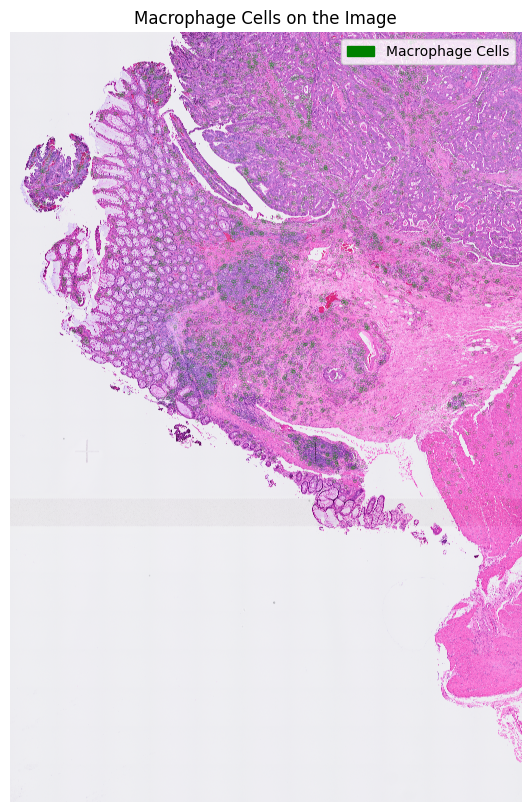

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.preprocessing import LabelEncoder

coordinates = []
labels = []
for cell_id, info in combined_cell_labels_and_centers.items():
    coordinates.append(info['center'])
    labels.append(info['label'])

coordinates = np.array(coordinates)
labels = np.array(labels)
margin=50
# Revert the numerical labels back to original string labels
# original_labels = label_encoder.inverse_transform(labels)
x_min = spots_df1['x'].min()
x_max = spots_df1['x'].max() + margin
y_min = spots_df1['y'].min()
y_max = spots_df1['y'].max() + margin

cropped_image = image_array[0:int(x_max), 0:int(y_max)]
# Plotting the image and the filtered coordinates
plt.figure(figsize=(10, 10))
plt.imshow(cropped_image / 255,origin='lower')  # Convert BGR to RGB for plotting
ax = plt.gca()

target_label = 'Macrophage'
#Interstitial_macrophage, Matrix_fibroblast', 'Vwf_endothelial_cell'
color = 'green'  # Define color for CD4

for i, coord in enumerate(coordinates):
    if labels[i] == target_label:
        circle = patches.Circle((coord[0], coord[1]), radius=2, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(circle)
# Creating a legend
legend_patches = [patches.Patch(color=color, label=f'{target_label} Cells')]
plt.legend(handles=legend_patches, loc='upper right')

plt.xlabel('Pixel Column in Full Resolution')
plt.ylabel('Pixel Row in Full Resolution')
plt.title(f'{target_label} Cells on the Image')
plt.axis('off')
plt.savefig(f'/ix1/wchen/Zhaochongyue/spatial/crc/p1/{target_label}.png', bbox_inches='tight',dpi=600, pad_inches=0)
plt.show()


In [43]:
# np.where(labels=='Vwf_endothelial_cell')# Define the three cell types you're interested in
interested_cell_types = ['CD4 T cell','CD8 Cytotoxic T cell','Macrophage','Mature B','CAF']

# Prepare a list to store the data of interested cells
interested_cells_data = []

for cell_id, cell_data in combined_cell_labels_and_centers.items():
    if cell_data['label'] in interested_cell_types:
        # Combine gene names with their corresponding expressions
        gene_expression_dict = {gene_name: expression for gene_name, expression in zip(final_gene_list, cell_data['gene_expression'])}
        
        # Create a dictionary to store the cell's label, center, and gene expressions
        cell_info = {
            'Cell ID': cell_id,
            'Label': cell_data['label'],
            'Center': cell_data['center'],
            **gene_expression_dict  # Add the gene expression data
        }
        
        # Append the cell information to the list
        interested_cells_data.append(cell_info)

# Convert the list of interested cells to a DataFrame
df_interested_cells = pd.DataFrame(interested_cells_data)


In [44]:

df_interested_cells[['y', 'x']] = pd.DataFrame(df_interested_cells['Center'].tolist(), index=df_interested_cells.index)

# Drop the 'Center' column as it has been split into 'x' and 'y'
df_interested_cells = df_interested_cells.drop(columns=['Center'])

# Rename 'Label' to 'cell_type' to match the structure of vwf_spots_df_combined
df_interested_cells = df_interested_cells.rename(columns={'Label': 'cell_type'})
# Merge df_interested_cells with vwf_spots_df_combined based on common columns like coordinates
final_combined_df = df_interested_cells



In [45]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
# Assuming adata_sc is an AnnData object with gene expression data and cell types
# Extract cell type information and gene expression from adata_sc
adata_cell_types = adata_sc.obs['Level2'].values
adata_gene_expression = adata_sc.X  # or adata_sc.to_df() if you want a DataFrame

# Extract relevant columns from final_combined_df
gene_expression_columns = final_combined_df.columns[2:-2]  # Gene expression columns (from 2nd to second last column)
final_gene_expression = final_combined_df[gene_expression_columns].values  # Gene expression data

# Initialize an array to hold the updated gene expression data
updated_gene_expression = np.zeros_like(final_gene_expression)

# Loop through each unique cell type in final_combined_df
for cell_type in final_combined_df['cell_type'].unique():
    # Filter cells of the current cell type in final_combined_df
    final_cells = final_combined_df[final_combined_df['cell_type'] == cell_type]
    
    # Filter cells of the same type in adata_sc
    adata_cells = adata_sc[adata_sc.obs['Level2'] == cell_type]
    adata_expression = adata_cells[:, gene_expression_columns].X  # Filtered gene expression data from adata_sc
    if isinstance(adata_expression, (np.matrix, np.ndarray)):
        adata_expression = adata_expression
    else:
        adata_expression = adata_expression.toarray()  # Convert to dense

    # Calculate the similarity (e.g., cosine similarity) within this cell type
    similarity_matrix = cosine_similarity(final_cells[gene_names].values, adata_expression)

    # Find the most similar cell for each cell in final_combined_df of this cell type
    most_similar_indices = np.argmax(similarity_matrix, axis=1)

    # Replace the gene expression data with the most similar cell's data from adata_sc
    for i, idx in enumerate(final_cells.index):
        updated_gene_expression[idx, :] = adata_expression[most_similar_indices[i], :]

# Update the final_combined_df with the new gene expression data
final_combined_df[gene_names] = updated_gene_expression
# final_combined_df.to_csv("final_combined_cells_data_crcp1.csv", index=False)

In [46]:
h5_file_path = '/ix1/wchen/liutianhao/data/public_lung_spatial/CRC_10X/singlecell/HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5'
adata_sc3 = sc.read_10x_h5(h5_file_path)
meta_data = pd.read_csv('/ix1/wchen/Zhaochongyue/spatial/SingleCell_MetaData.csv')
# meta_data = pd.read_csv(meta_data_csv_path)

# Display the first few rows of meta_data to understand its structure
print(meta_data.head())

# Filter clusters with more than 25 cells
kp_idents = meta_data['Level2'].value_counts()[meta_data['Level2'].value_counts() > 25].index
filtered_meta_data = meta_data[meta_data['Level2'].isin(kp_idents)]

# Ensure barcodes match in format between adata and meta_data
adata_barcodes = adata_sc3.obs_names
meta_data_barcodes = filtered_meta_data['Barcode']

# Check the intersection of barcodes
common_barcodes = np.intersect1d(adata_barcodes, meta_data_barcodes)

# Subset AnnData to only include the common barcodes
adata_sc3 = adata_sc3[common_barcodes]

# Also filter the metadata to include only common barcodes
filtered_meta_data = filtered_meta_data[filtered_meta_data['Barcode'].isin(common_barcodes)]

# Set the Barcode as index to facilitate merging
filtered_meta_data.set_index('Barcode', inplace=True)

# Align the indices (barcodes) of the filtered metadata with the AnnData object
adata_sc3.obs = adata_sc3.obs.join(filtered_meta_data, how='left')

adata_sc3.var_names_make_unique()
names = ['P1_CRC']
datasets = {}
# all_centroids = []  # List to store all centroids
# all_images = []  # List to store all images
for name in names:
    datasets[name] = get_cnt(name)
    datasets[name].var_names_make_unique()
# Find common genes between single-cell and other datasets
common_genes = set(adata_sc.var_names)
for data in datasets.values():
    common_genes.intersection_update(set(data.var_names))
adata_sc3 = adata_sc3[:, list(common_genes)]
for name in datasets:
    datasets[name] = datasets[name][:, list(common_genes)]
adata_sc3 = adata_sc3[adata_sc3.obs['QCFilter'] == "Keep"]


sc.pp.normalize_total(adata_sc3, target_sum=1e4)

sc.pp.log1p(adata_sc3)

                      Barcode Patient   BC QCFilter       Level1       Level2
0  AAACAAGCAACAGCACACTTTAGG-1   P2CRC  BC1   Remove  QC_Filtered  QC_Filtered
1  AAACAAGCAACAGCTAACTTTAGG-1   P2CRC  BC1     Keep      B cells       Plasma
2  AAACAAGCAACTGTTCACTTTAGG-1   P2CRC  BC1     Keep      T cells   CD4 T cell
3  AAACAAGCAAGGCCTGACTTTAGG-1   P2CRC  BC1     Keep        Tumor    Tumor III
4  AAACAAGCACATAGTGACTTTAGG-1   P2CRC  BC1     Keep        Tumor    Tumor III


In [47]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# Assuming adata_sc is an AnnData object with gene expression data and cell types
# Extract cell type information and gene expression from adata_sc
adata_cell_types = adata_sc.obs['Level2'].values
adata_gene_expression = adata_sc.X  # or adata_sc.to_df() if you want a DataFrame
# adata_gene_expression1 = adata_sc2.X 
# Extract relevant columns from final_combined_df
gene_expression_columns = final_combined_df.columns[2:-2]  # Gene expression columns (from 2nd to second last column)
final_gene_expression = final_combined_df[gene_expression_columns].values  # Gene expression data
gene_names = final_gene_list

updated_gene_expression = np.zeros((final_gene_expression.shape[0], adata_gene_expression.shape[1]))

for cell_type in final_combined_df['cell_type'].unique():
    # Filter cells of the current cell type in final_combined_df
    final_cells = final_combined_df[final_combined_df['cell_type'] == cell_type]
    
    # Filter cells of the same type in adata_sc
    adata_cells = adata_sc[adata_sc.obs['Level2'] == cell_type]
    adata_cells2 = adata_sc3[adata_sc3.obs['Level2'] == cell_type]
    adata_expression = adata_cells[:, gene_expression_columns].X  # Filtered gene expression data from adata_sc
    adata_expression2 = adata_cells2[:, gene_expression_columns].X 
    if isinstance(adata_expression, (np.matrix, np.ndarray)):
        adata_expression = adata_expression
    else:
        adata_expression = adata_expression.toarray()  # Convert to dense
    if isinstance(adata_expression2, (np.matrix, np.ndarray)):
        adata_expression2 = adata_expression2
    else:
        adata_expression2 = adata_expression2.toarray()  # Convert to dense
    distance_matrix = euclidean_distances(final_cells[gene_names].values, adata_expression)

## Find the index of the most similar cell in adata_expression
    top_5_indices = np.argsort(distance_matrix, axis=1)[:, :5]

    # Replace the gene expression data with the average of the top 5 similar cells from adata_expression2
    for i, idx in enumerate(final_cells.index):
        # Get the top 5 similar cells' expression values
        similar_cells_expression = adata_expression2[top_5_indices[i], :]
        
        # Average the expression values of the top 5 similar cells
        avg_expression = np.mean(similar_cells_expression, axis=0)
        
        # Update the gene expression for the current cell
        updated_gene_expression[idx, :] = avg_expression

# Step 2: Convert updated_gene_expression into a DataFrame
updated_gene_expression_df = pd.DataFrame(updated_gene_expression, index=final_combined_df.index, columns=gene_names)

# Overwrite any existing columns with the same names
final_combined_df_extended = final_combined_df.copy()

# Update the DataFrame with new gene expression data
final_combined_df_extended.update(updated_gene_expression_df)

# Add any non-overlapping columns from updated_gene_expression_df
non_overlapping_columns = updated_gene_expression_df.columns.difference(final_combined_df.columns)
final_combined_df_extended = pd.concat([final_combined_df_extended, updated_gene_expression_df[non_overlapping_columns]], axis=1)

# Optionally, save the updated DataFrame to a CSV file
final_combined_df_extended.to_csv("/ix1/wchen/Zhaochongyue/spatial/crc/p1/crc_p1_top5_1.csv", index=False)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

# Define variables based on your inputs
adata_cell_types = adata_sc.obs['Level2'].values
adata_gene_expression = adata_sc.X  # Gene expression data from adata_sc
gene_expression_columns = final_combined_df.columns[2:-2]  # Gene expression columns in final_combined_df
final_gene_expression = final_combined_df[gene_expression_columns].values  # Gene expression data
gene_names = final_gene_list

# Initialize an array to hold the updated gene expression data
updated_gene_expression = np.zeros((final_gene_expression.shape[0], adata_gene_expression.shape[1]))

# Step 1: Perform Clustering for Macrophage Subtypes in adata_sc
macrophage_cells = adata_sc[adata_sc.obs['Level2'] == 'Macrophage']
macrophage_expression = macrophage_cells[:, gene_expression_columns].X

# Convert to dense if necessary
if not isinstance(macrophage_expression, (np.matrix, np.ndarray)):
    macrophage_expression = macrophage_expression.toarray()

# Perform clustering to find subtypes within macrophages
n_clusters = 2  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(macrophage_expression)

# Assign the cluster labels as a new column in the adata_sc object
adata_sc.obs.loc[adata_sc.obs['Level2'] == 'Macrophage', 'subtype'] = cluster_labels

# Assign the same cluster labels to adata_sc3 since they share the same structure and indices
adata_sc3.obs['subtype'] = adata_sc.obs['subtype']

# Step 2: Calculate the centroid for each subtype in adata_sc3
subtype_centroids = {}
for subtype in adata_sc3.obs['subtype'].unique():
    subtype_cells = adata_sc3[(adata_sc3.obs['Level2'] == 'Macrophage') & (adata_sc3.obs['subtype'] == subtype)]
    if len(subtype_cells) > 0:
        subtype_centroids[subtype] = np.mean(subtype_cells[:, gene_expression_columns].X, axis=0)

# Step 3: Calculate the centroid for macrophages in final_combined_df
final_macrophage_cells = final_combined_df[final_combined_df['cell_type'] == 'Macrophage']
final_macrophage_centroid = np.mean(final_macrophage_cells[gene_names].values, axis=0)

# Step 4: Find the closest matching subtype centroid
min_distance = float('inf')
closest_subtype = None
for ref_subtype, ref_centroid in subtype_centroids.items():
    distance = np.linalg.norm(final_macrophage_centroid - ref_centroid)
    if distance < min_distance:
        min_distance = distance
        closest_subtype = ref_subtype

# Step 5: Use the closest matching subtype to map and update gene expressions in final_combined_df
if closest_subtype is not None:
    # Filter cells of the closest matching subtype in adata_sc3
    ref_cells_closest_subtype = adata_sc3[(adata_sc3.obs['Level2'] == 'Macrophage') & (adata_sc3.obs['subtype'] == closest_subtype)]
    ref_expression = ref_cells_closest_subtype[:, gene_expression_columns].X
    
    # Convert sparse matrix to dense if needed
    if not isinstance(ref_expression, (np.matrix, np.ndarray)):
        ref_expression = ref_expression.toarray()
    
    # Calculate distances between final_combined_df macrophages and reference subtype cells
    distance_matrix = euclidean_distances(final_macrophage_cells[gene_names].values, ref_expression)
    
    # Find the top 5 closest cells in the reference subtype
    top_5_indices = np.argsort(distance_matrix, axis=1)[:, :5]
    
    # Update gene expression using the average of the top 5 closest cells
    for i, idx in enumerate(final_macrophage_cells.index):
        similar_cells_expression = ref_expression[top_5_indices[i], :]
        
        # Calculate the average expression of the top 5 similar cells
        avg_expression = np.mean(similar_cells_expression, axis=0)
        
        # Update the gene expression for the current cell
        updated_gene_expression[idx, :] = avg_expression

# Step 6: Process non-macrophage cell types in final_combined_df
for cell_type in final_combined_df['cell_type'].unique():
    if cell_type != 'Macrophage':
        final_cells = final_combined_df[final_combined_df['cell_type'] == cell_type]
        adata_cells = adata_sc[adata_sc.obs['Level2'] == cell_type]
        adata_cells2 = adata_sc3[adata_sc3.obs['Level2'] == cell_type]
        adata_expression = adata_cells[:, gene_expression_columns].X
        adata_expression2 = adata_cells2[:, gene_expression_columns].X 
        if not isinstance(adata_expression, (np.matrix, np.ndarray)):
            adata_expression = adata_expression.toarray()  
        if not isinstance(adata_expression2, (np.matrix, np.ndarray)):
            adata_expression2 = adata_expression2.toarray()  
        
        # Calculate the similarity (e.g., euclidean distance) within this cell type
        distance_matrix = euclidean_distances(final_cells[gene_names].values, adata_expression)
        
        # Find the index of the most similar cells in adata_expression
        top_5_indices = np.argsort(distance_matrix, axis=1)[:, :5]
        
        # Replace the gene expression data with the average of the top 5 similar cells from adata_expression2
        for i, idx in enumerate(final_cells.index):
            # Get the top 5 similar cells' expression values
            similar_cells_expression = adata_expression2[top_5_indices[i], :]
            
            # Average the expression values of the top 5 similar cells
            avg_expression = np.mean(similar_cells_expression, axis=0)
            
            # Update the gene expression for the current cell
            updated_gene_expression[idx, :] = avg_expression

# Step 7: Convert updated_gene_expression into a DataFrame
updated_gene_expression_df = pd.DataFrame(updated_gene_expression, index=final_combined_df.index, columns=gene_names)

# Display the final DataFrame
# Overwrite any existing columns with the same names
final_combined_df_extended = final_combined_df.copy()

# Update the DataFrame with new gene expression data
final_combined_df_extended.update(updated_gene_expression_df)

# Add any non-overlapping columns from updated_gene_expression_df
non_overlapping_columns = updated_gene_expression_df.columns.difference(final_combined_df.columns)
final_combined_df_extended = pd.concat([final_combined_df_extended, updated_gene_expression_df[non_overlapping_columns]], axis=1)

# Optionally, save the updated DataFrame to a CSV file
final_combined_df_extended.to_csv("/ix1/wchen/Zhaochongyue/spatial/crc/p1/crc_p1_top5_subtype.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
# Assuming adata_sc is an AnnData object with gene expression data and cell types
# Extract cell type information and gene expression from adata_sc
adata_cell_types = adata_sc.obs['Level2'].values
adata_gene_expression = adata_sc.X  # or adata_sc.to_df() if you want a DataFrame
# adata_gene_expression1 = adata_sc2.X 
# Extract relevant columns from final_combined_df
gene_expression_columns = final_combined_df.columns[2:-2]  # Gene expression columns (from 2nd to second last column)
final_gene_expression = final_combined_df[gene_expression_columns].values  # Gene expression data
gene_names = final_gene_list

updated_gene_expression = np.zeros((final_gene_expression.shape[0], adata_gene_expression.shape[1]))

for cell_type in final_combined_df['cell_type'].unique():
    # Filter cells of the current cell type in final_combined_df
    final_cells = final_combined_df[final_combined_df['cell_type'] == cell_type]
    
    # Filter cells of the same type in adata_sc
    adata_cells = adata_sc[adata_sc.obs['Level2'] == cell_type]
    adata_cells2 = adata_sc3[adata_sc3.obs['Level2'] == cell_type]
    adata_expression = adata_cells[:, gene_expression_columns].X  # Filtered gene expression data from adata_sc
    adata_expression2 = adata_cells2[:, gene_expression_columns].X 
    if isinstance(adata_expression, (np.matrix, np.ndarray)):
        adata_expression = adata_expression
    else:
        adata_expression = adata_expression.toarray()  # Convert to dense
    if isinstance(adata_expression2, (np.matrix, np.ndarray)):
        adata_expression2 = adata_expression2
    else:
        adata_expression2 = adata_expression2.toarray()  # Convert to dense
    # Calculate the similarity (e.g., cosine similarity) within this cell type
    # similarity_matrix = cosine_similarity(final_cells[gene_names].values, adata_expression)

    # # Find the most similar cell for each cell in final_combined_df of this cell type
    # most_similar_indices = np.argmax(similarity_matrix, axis=1)
    distance_matrix = euclidean_distances(final_cells[gene_names].values, adata_expression)

# Find the closest cell by finding the index of the minimum distance for each cell
    most_similar_indices = np.argmin(distance_matrix, axis=1)
    # Replace the gene expression data with the most similar cell's data from adata_sc
    for i, idx in enumerate(final_cells.index):
        updated_gene_expression[idx, :] = adata_expression2[most_similar_indices[i], :]
# gene_names = adata_sc3.var_names

# Step 2: Convert updated_gene_expression into a DataFrame
updated_gene_expression_df = pd.DataFrame(updated_gene_expression, index=final_combined_df.index, columns=gene_names)

# Overwrite any existing columns with the same names
final_combined_df_extended = final_combined_df.copy()

# Update the DataFrame with new gene expression data
final_combined_df_extended.update(updated_gene_expression_df)

# Add any non-overlapping columns from updated_gene_expression_df
non_overlapping_columns = updated_gene_expression_df.columns.difference(final_combined_df.columns)
final_combined_df_extended = pd.concat([final_combined_df_extended, updated_gene_expression_df[non_overlapping_columns]], axis=1)

# Optionally, save the updated DataFrame to a CSV file
final_combined_df_extended.to_csv("/ix1/wchen/Zhaochongyue/spatial/crc/p1/crc_p1.csv", index=False)

        # gene_names=adata_sc3.
# Update the final_combined_df with the new gene expression data
# final_combined_df1[gene_names] = updated_gene_expression
# final_combined_df.to_csv("final_combined_cells_data.csv", index=False)

In [ ]:
final_cells.index

In [ ]:
print(np.min(adata_expression2), np.max(adata_expression2))

In [50]:
final_combined_df_extended

Cell ID   cell_type  CXCL9  PRF1  GZMK  GZMA  CXCL11  JCHAIN  MZB1  \
0         1068  CD4 T cell    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
1         2209  Macrophage    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
2         2212  Macrophage    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
3         2230  Macrophage    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
4         2253  CD4 T cell    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
...        ...         ...    ...   ...   ...   ...     ...     ...   ...   
17674   133433  Macrophage    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
17675   133435         CAF    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
17676   133436         CAF    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
17677   133504  CD4 T cell    0.0   0.0   0.0   0.0     0.0     0.0   0.0   
17678   133735  Macrophage    0.0   0.0   0.0   0.0     0.0     0.0   0.0   

           ATF3  ...    CXCL10  ITK  IFNG      CTSL  GJA5  KRT77  ZNF735  \
0      0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
1      0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
2      0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
3      0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
4      0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
...         ...  ...       ...  ...   ...       ...   ...    ...     ...   
17674  0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
17675  0.000000  ...  5.630415  0.0   0.0  0.000000   0.0    0.0     0.0   
17676  4.325812  ...  0.000000  0.0   0.0  4.325812   0.0    0.0     0.0   
17677  0.000000  ...  0.000000  0.0   0.0  0.000000   0.0    0.0     0.0   
17678  0.000000  ...  0.000000  0.0   0.0  4.931698   0.0    0.0     0.0   

       CARTPT             y             x  
0         0.0  23963.394531  13362.846680  
1         0.0  23810.613281  14077.470703  
2         0.0  21852.677734  14088.697266  
3         0.0  21852.677734  14088.697266  
4         0.0  23620.416016  14104.947266  
...       ...           ...           ...  
17674     0.0  15329.774414  36735.816406  
17675     0.0  18865.171875  36753.929688  
17676     0.0  19654.042969  36761.226562  
17677     0.0  19741.558594  36776.652344  
17678     0.0  23890.486328  36815.050781  

[17679 rows x 1004 columns]